In [1]:
## Importing necessary Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.pylab import rcParams

import time
from collections import Counter
from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns',None)
pd.set_option('max_rows',60)


from sklearn.model_selection import StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator,clone,TransformerMixin,ClassifierMixin


from scipy import stats
from scipy.stats import norm,skew
rcParams['figure.figsize']=12,10

from tqdm import tqdm_notebook


import xgboost as xgb
import lightgbm as lgb


In [2]:
## color style 
cmap = ListedColormap(['Blue','Red'])

In [3]:
print(check_output(['ls','../input']).decode('utf-8'))

kag_risk_factors_cervical_cancer.csv



In [4]:
## Reducing memory Ram memroy
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
df = reduce_mem_usage(pd.read_csv('../input/kag_risk_factors_cervical_cancer.csv'))
df.shape

Mem. usage decreased to  0.18 Mb (24.3% reduction)


(858, 36)

In [6]:
df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [7]:
col = list(df.columns)
for i,x in enumerate(col,0):
    col[i] =  str(x).replace(' ','_')
df.columns = col

In [8]:
## First 5 rows
df.head()

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_(years),Smokes_(packs/year),Hormonal_Contraceptives,Hormonal_Contraceptives_(years),IUD,IUD_(years),STDs,STDs_(number),STDs:condylomatosis,STDs:cervical_condylomatosis,STDs:vaginal_condylomatosis,STDs:vulvo-perineal_condylomatosis,STDs:syphilis,STDs:pelvic_inflammatory_disease,STDs:genital_herpes,STDs:molluscum_contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis_B,STDs:HPV,STDs:_Number_of_diagnosis,STDs:_Time_since_first_diagnosis,STDs:_Time_since_last_diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


In [9]:
##Data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int8
Number_of_sexual_partners             858 non-null object
First_sexual_intercourse              858 non-null object
Num_of_pregnancies                    858 non-null object
Smokes                                858 non-null object
Smokes_(years)                        858 non-null object
Smokes_(packs/year)                   858 non-null object
Hormonal_Contraceptives               858 non-null object
Hormonal_Contraceptives_(years)       858 non-null object
IUD                                   858 non-null object
IUD_(years)                           858 non-null object
STDs                                  858 non-null object
STDs_(number)                         858 non-null object
STDs:condylomatosis                   858 non-null object
STDs:cervical_condylomatosis          858 non-null object
STDs:vaginal_condylomatosis

In [10]:
## replacing ? with np.na
df_ = df.replace('?',np.nan)

In [11]:
df_.isnull().sum()

Age                                     0
Number_of_sexual_partners              26
First_sexual_intercourse                7
Num_of_pregnancies                     56
Smokes                                 13
Smokes_(years)                         13
Smokes_(packs/year)                    13
Hormonal_Contraceptives               108
Hormonal_Contraceptives_(years)       108
IUD                                   117
IUD_(years)                           117
STDs                                  105
STDs_(number)                         105
STDs:condylomatosis                   105
STDs:cervical_condylomatosis          105
STDs:vaginal_condylomatosis           105
STDs:vulvo-perineal_condylomatosis    105
STDs:syphilis                         105
STDs:pelvic_inflammatory_disease      105
STDs:genital_herpes                   105
STDs:molluscum_contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis_B                  

In [12]:
df = df_.convert_objects(convert_numeric=True)

In [13]:
df_ =df.copy()

In [14]:
df.describe()

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_(years),Smokes_(packs/year),Hormonal_Contraceptives,Hormonal_Contraceptives_(years),IUD,IUD_(years),STDs,STDs_(number),STDs:condylomatosis,STDs:cervical_condylomatosis,STDs:vaginal_condylomatosis,STDs:vulvo-perineal_condylomatosis,STDs:syphilis,STDs:pelvic_inflammatory_disease,STDs:genital_herpes,STDs:molluscum_contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis_B,STDs:HPV,STDs:_Number_of_diagnosis,STDs:_Time_since_first_diagnosis,STDs:_Time_since_last_diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,832.000000,851.000000,802.000000,845.000000,845.000000,845.000000,750.000000,750.000000,741.000000,741.000000,753.000000,753.000000,753.000000,753.0,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.0,753.000000,753.000000,753.000000,858.000000,71.000000,71.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.527644,16.995300,2.275561,0.145562,1.219721,0.453144,0.641333,2.256419,0.112011,0.514804,0.104914,0.176627,0.058433,0.0,0.005312,0.057105,0.023904,0.001328,0.001328,0.001328,0.0,0.023904,0.001328,0.002656,0.087413,6.140845,5.816901,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,1.667760,2.803355,1.447414,0.352876,4.089017,2.226610,0.479929,3.764254,0.315593,1.943089,0.306646,0.561993,0.234716,0.0,0.072739,0.232197,0.152853,0.036442,0.036442,0.036442,0.0,0.152853,0.036442,0.051503,0.302545,5.895024,5.755271,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,8.000000,7.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,30.000000,1.000000,19.000000,1.000000,4.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,3.000000,22.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
gg_  =df.copy()

In [16]:
df_.dtypes

Age                                     int64
Number_of_sexual_partners             float64
First_sexual_intercourse              float64
Num_of_pregnancies                    float64
Smokes                                float64
Smokes_(years)                        float64
Smokes_(packs/year)                   float64
Hormonal_Contraceptives               float64
Hormonal_Contraceptives_(years)       float64
IUD                                   float64
IUD_(years)                           float64
STDs                                  float64
STDs_(number)                         float64
STDs:condylomatosis                   float64
STDs:cervical_condylomatosis          float64
STDs:vaginal_condylomatosis           float64
STDs:vulvo-perineal_condylomatosis    float64
STDs:syphilis                         float64
STDs:pelvic_inflammatory_disease      float64
STDs:genital_herpes                   float64
STDs:molluscum_contagiosum            float64
STDs:AIDS                         

## Analysis of target varibles

Counter({0: 803, 1: 55})

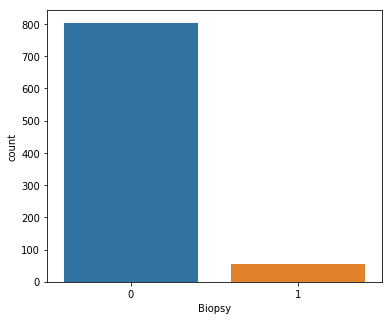

In [17]:
plt.figure(figsize=(6,5))
sns.countplot(df.Biopsy)
Counter(df.Biopsy)


## Quick baseline

In [18]:
def baseline(df):
    rcParams['figure.figsize']=12,10
    df_ =df.copy()
    numerical_feats = df_.select_dtypes(exclude='O').columns
    df_ = df_.fillna(0)
    X = df_.drop(columns='Biopsy')
    y= df_.Biopsy.values
    rf = RandomForestClassifier(n_estimators=100,random_state=1)
    rf.fit(X,y)
    kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1) 
    score = cross_val_score(rf,X,y,scoring='accuracy',cv=kfold,n_jobs=-1,verbose=1)
    features = pd.DataFrame(rf.feature_importances_,index=X.columns).reset_index().sort_values(0,ascending=False)
    features.columns=['Features','Score']
    sns.barplot(y='Features',x='Score',data=features,)
    predict = rf.predict(X)
    #return predict
    return score.mean(),score.std(),score.min(),score.max()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


(0.947531619747042, 0.011777976898401757, 0.9239766081871345, 0.9534883720930233)


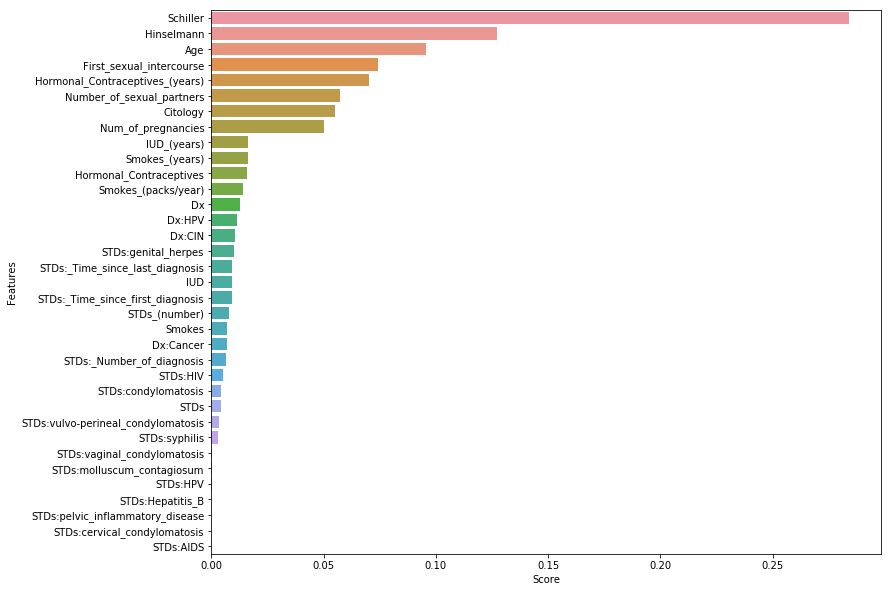

In [19]:
print(baseline(df))

## Schiller,Hinselmann

Counter({0: 784, 1: 74})

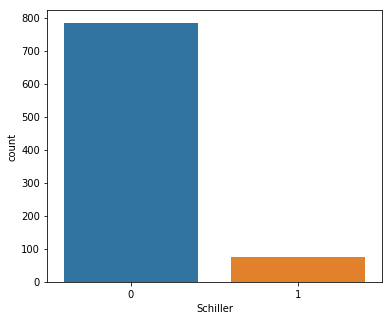

In [20]:
plt.figure(figsize=(6,5))
sns.countplot(df.Schiller)
Counter(df.Schiller)

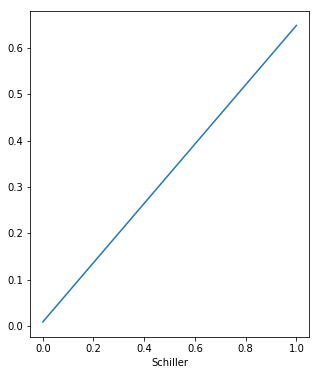

In [21]:
plt.figure(figsize=(5,6))
df.groupby('Schiller')['Biopsy'].mean().plot()

Counter({0: 823, 1: 35})

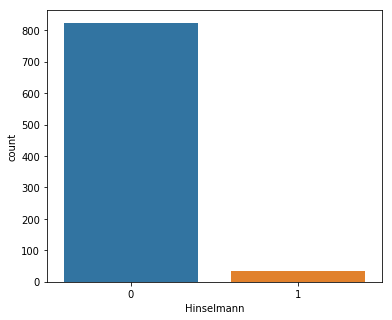

In [22]:
plt.figure(figsize=(6,5))
sns.countplot(df.Hinselmann)
Counter(df.Hinselmann)

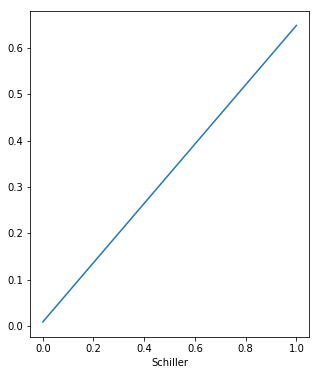

In [23]:
plt.figure(figsize=(5,6))
df.groupby('Schiller')['Biopsy'].mean().plot()

## Missing values

In [24]:
df_.isnull().sum(axis=1).sort_values(ascending=False).head(15)

279    23
552    23
117    23
272    22
71     22
460    21
304    21
544    21
696    21
700    21
495    21
701    21
705    21
220    21
398    21
dtype: int64

In [25]:
df_.isnull().sum().sort_values(ascending=False)

STDs:_Time_since_last_diagnosis       787
STDs:_Time_since_first_diagnosis      787
IUD_(years)                           117
IUD                                   117
Hormonal_Contraceptives               108
Hormonal_Contraceptives_(years)       108
STDs:molluscum_contagiosum            105
STDs                                  105
STDs_(number)                         105
STDs:condylomatosis                   105
STDs:cervical_condylomatosis          105
STDs:vaginal_condylomatosis           105
STDs:vulvo-perineal_condylomatosis    105
STDs:pelvic_inflammatory_disease      105
STDs:genital_herpes                   105
STDs:syphilis                         105
STDs:AIDS                             105
STDs:Hepatitis_B                      105
STDs:HPV                              105
STDs:HIV                              105
Num_of_pregnancies                     56
Number_of_sexual_partners              26
Smokes_(packs/year)                    13
Smokes_(years)                    

## missing values in the same rows

In [26]:
df[df['Smokes_(years)'].isnull()]['Smokes_(packs/year)'].shape

(13,)

In [27]:
df_[df_['STDs:_Time_since_last_diagnosis'].isnull()]['STDs:_Time_since_first_diagnosis'].shape

(787,)

In [28]:
df_[df_['IUD_(years)'].isnull()]['IUD'].shape

(117,)

In [29]:
df_[df_['Hormonal_Contraceptives'].isnull()]['Hormonal_Contraceptives_(years)'].shape

(108,)

In [30]:
df_[df_['STDs_(number)'].isnull()][['STDs:condylomatosis','STDs:cervical_condylomatosis','STDs:vaginal_condylomatosis','STDs:vulvo-perineal_condylomatosis','STDs:pelvic_inflammatory_disease','STDs:genital_herpes','STDs:syphilis','STDs:AIDS','STDs:Hepatitis_B','STDs:HPV','STDs:HIV']].shape                    


(105, 11)

## Applying Stradified cross validation 
### Scoring matrice =' Roc_auc_score'

In [31]:
def score_cv(clf,X,y):
    score = cross_val_score(clf,X,y,scoring='roc_auc',cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True),n_jobs=-1,verbose=0)
    return score

In [32]:
def run_experiment(preprocess):
    _ = df.copy()
    _ = preprocess(_)
    X, y = _.drop(labels='Biopsy',axis=1),_.Biopsy
    model = RandomForestClassifier(n_estimators=100,max_features=0.3,n_jobs=-1,random_state=1)
    score = score_cv(model,X,y)
    return score

In [33]:
def run_experiments(preprocesses):
    results = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        execution_time = time.time() - start
        results.append({
            'name': preprocess.__name__,
            'score': score.mean(),
            '+-score_std':score.std(),
            'score_min':score.min(),
            'score_max':score.max(),
            'execution time': f'{round(execution_time, 2)}s'
        })
        
    return pd.DataFrame(results, columns=['name', 'score','+-score_std','score_min','score_max', 'execution time']).sort_values(by='score',ascending=False)

## Unique varibles in data

In [34]:
nunique = df_.nunique(dropna=False).sort_values()/len(df)

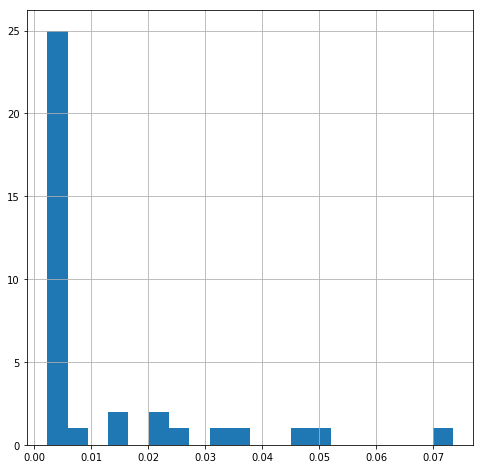

In [35]:
plt.figure(figsize=(8,8))
fig = nunique.hist(bins=20)

## Data distributions

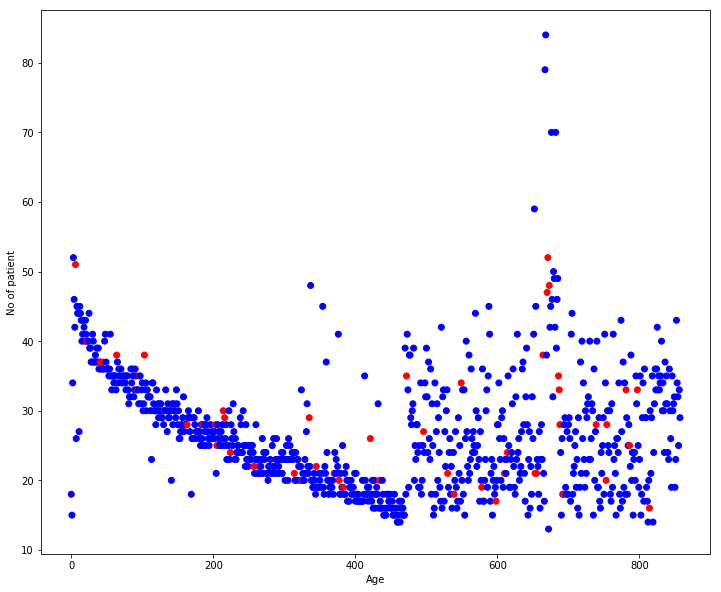

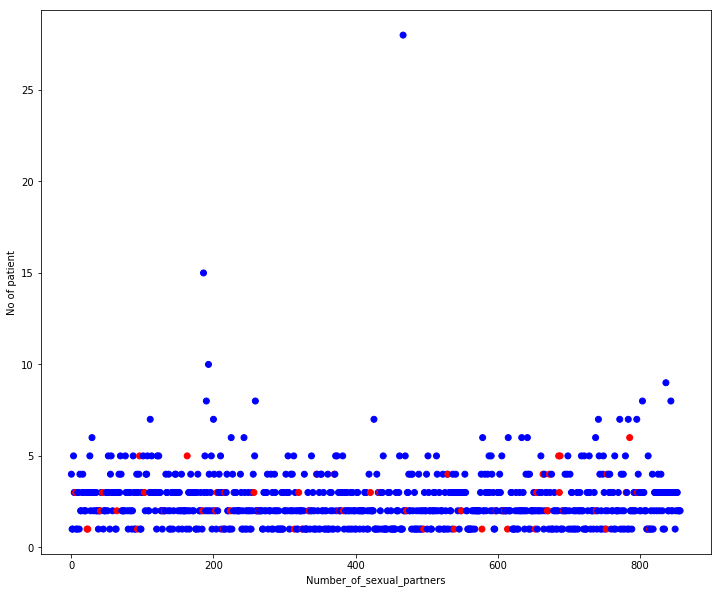

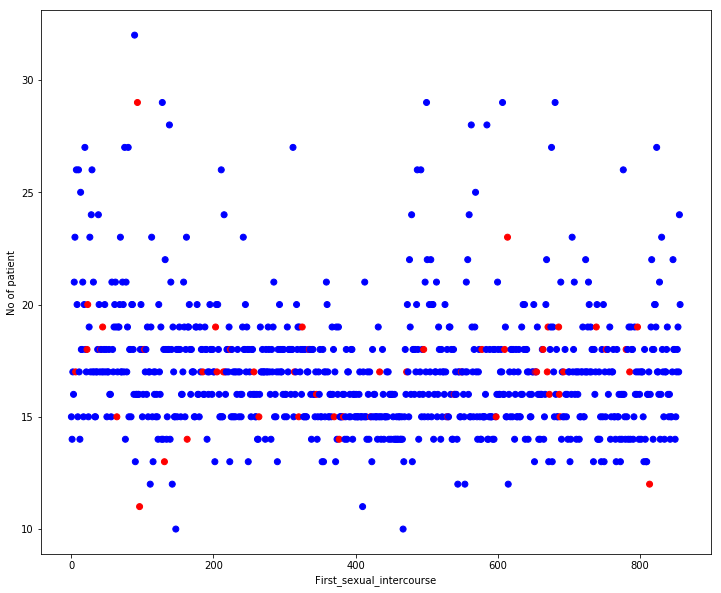

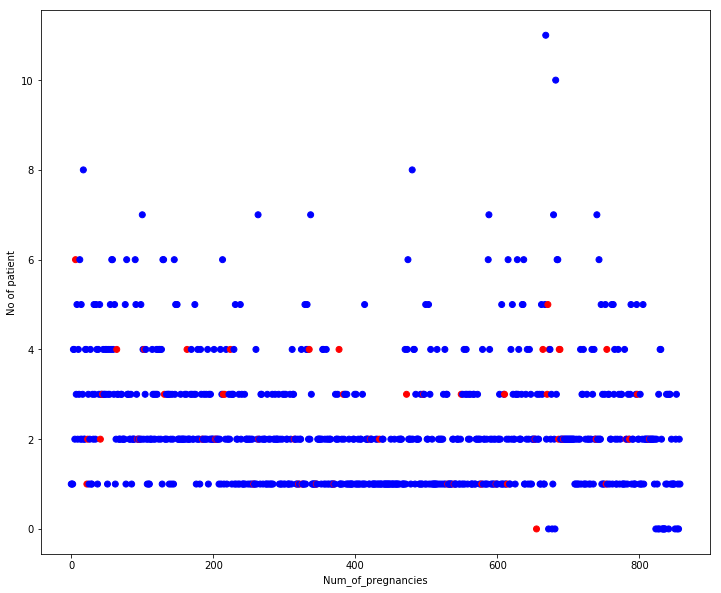

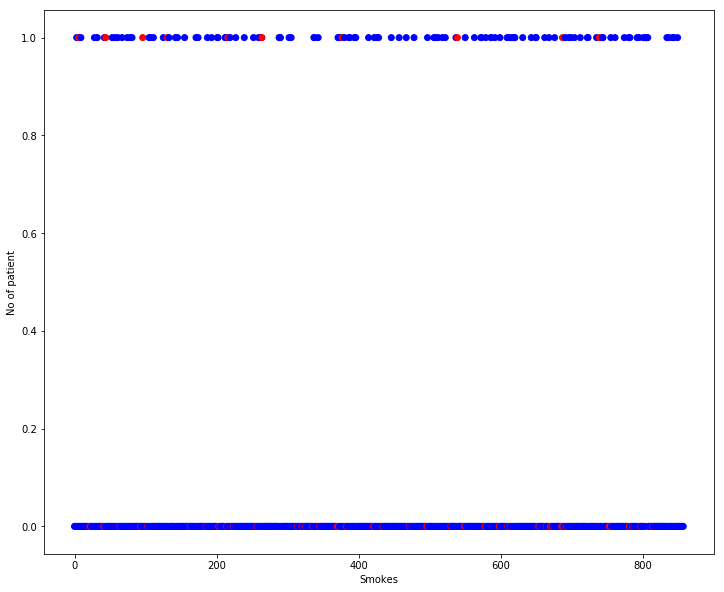

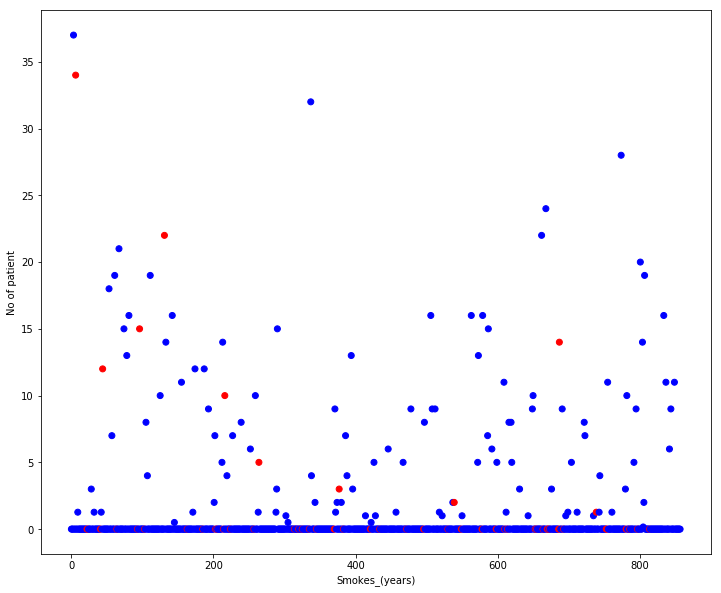

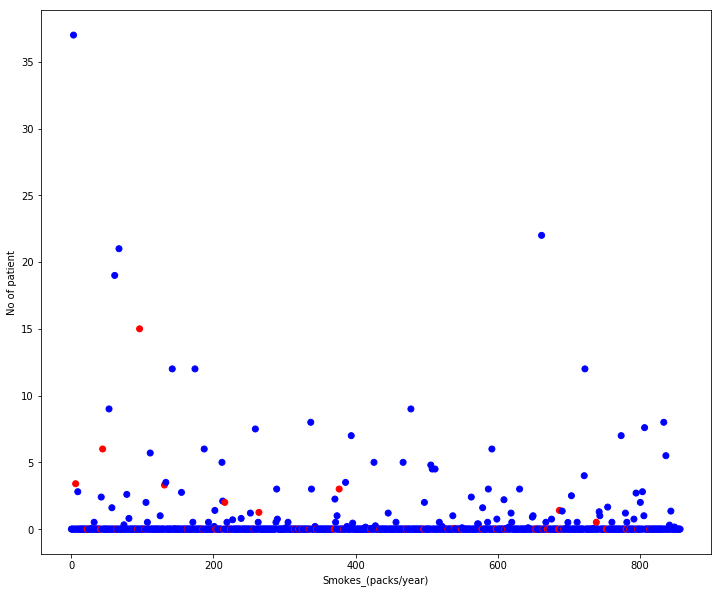

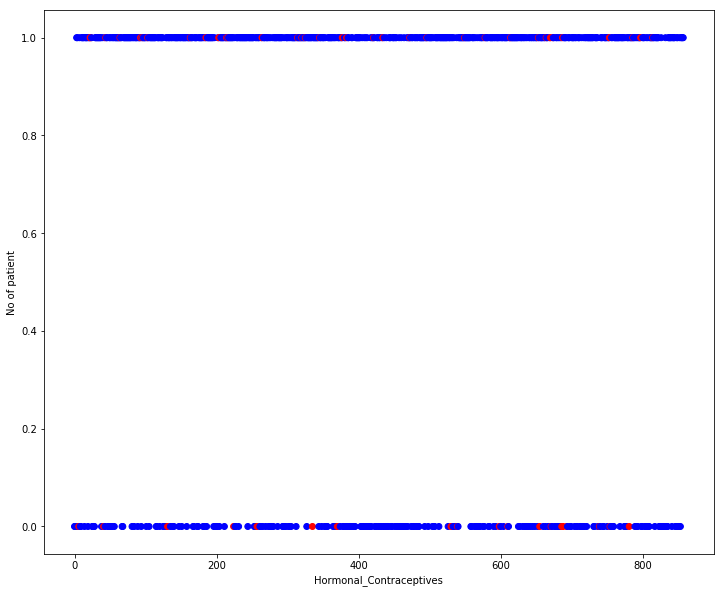

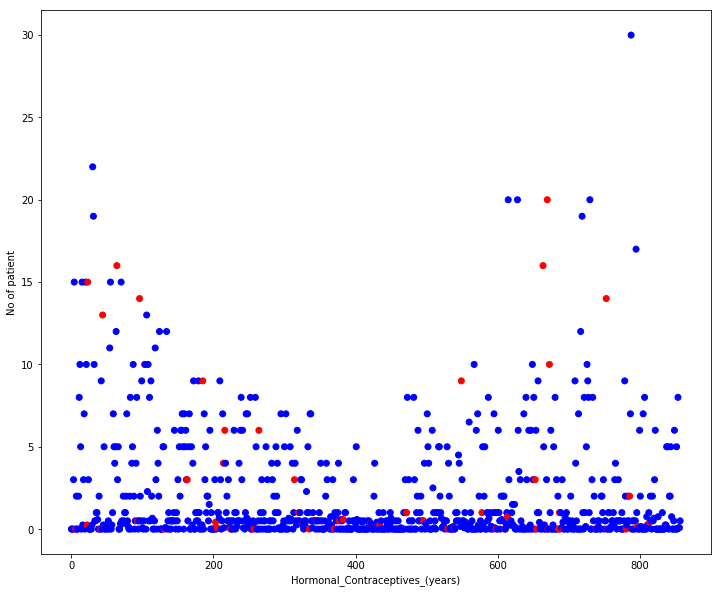

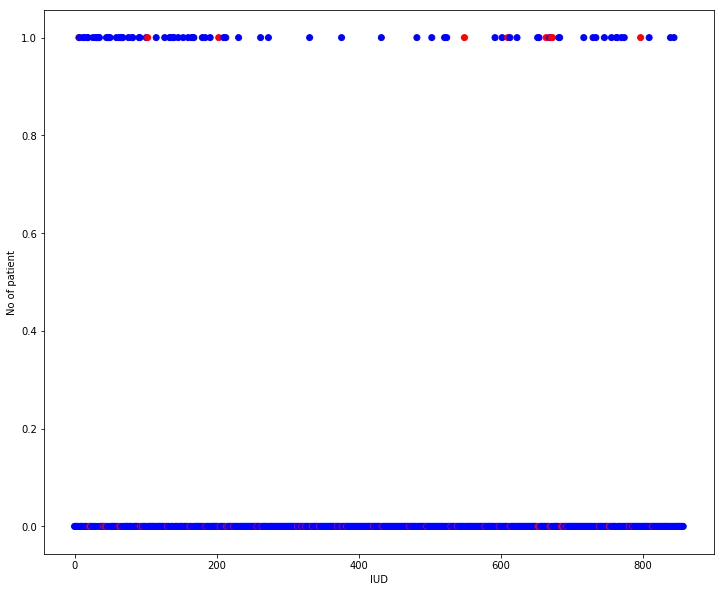

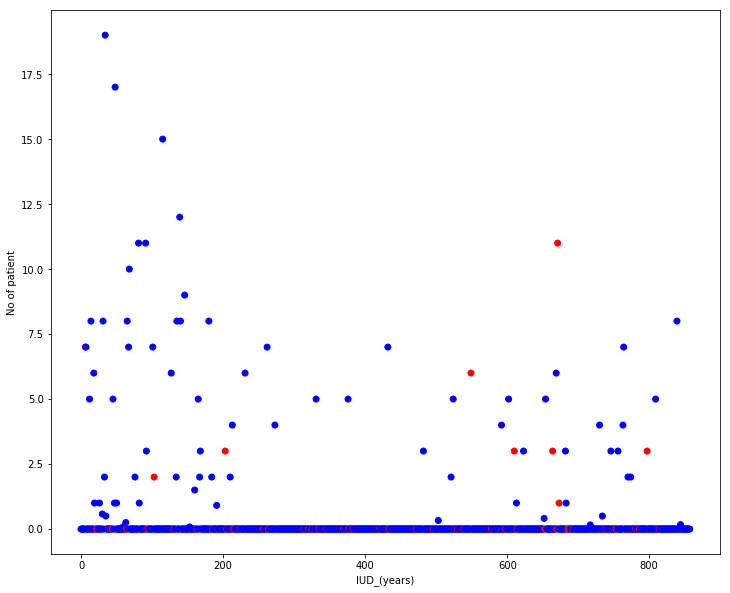

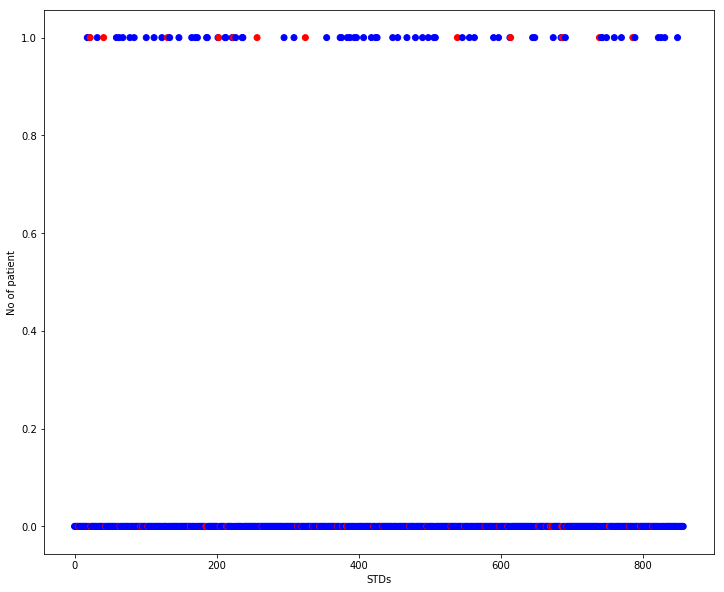

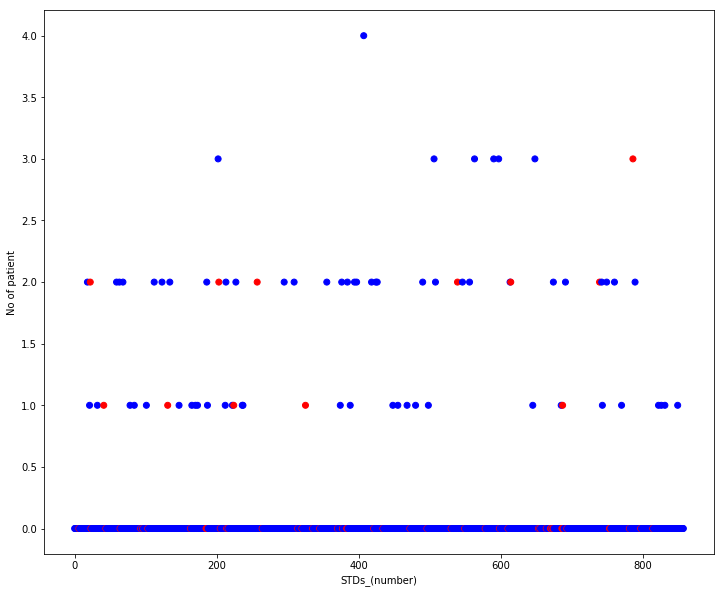

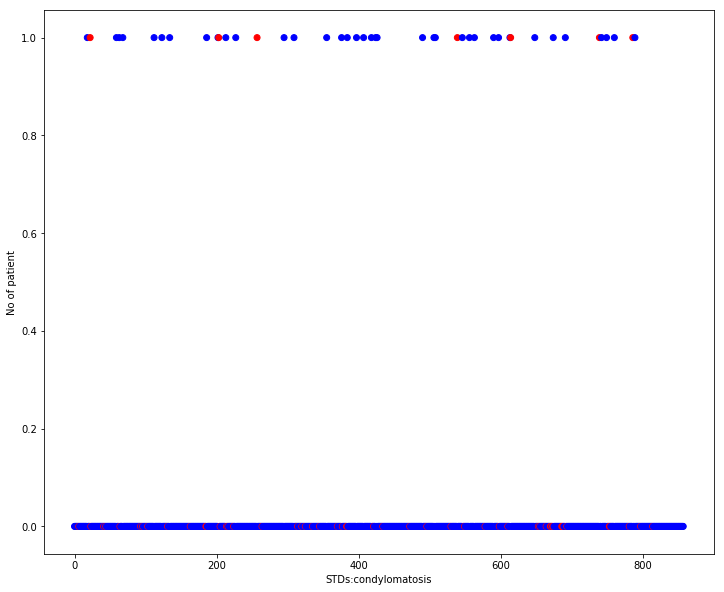

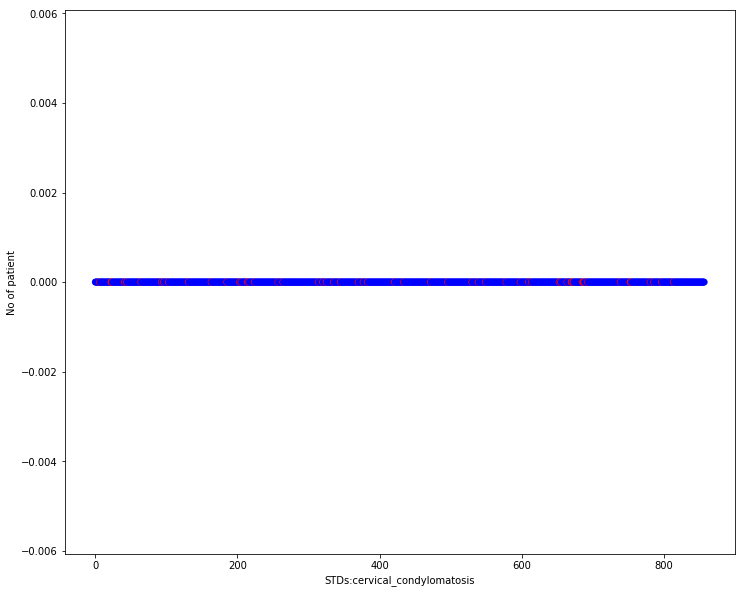

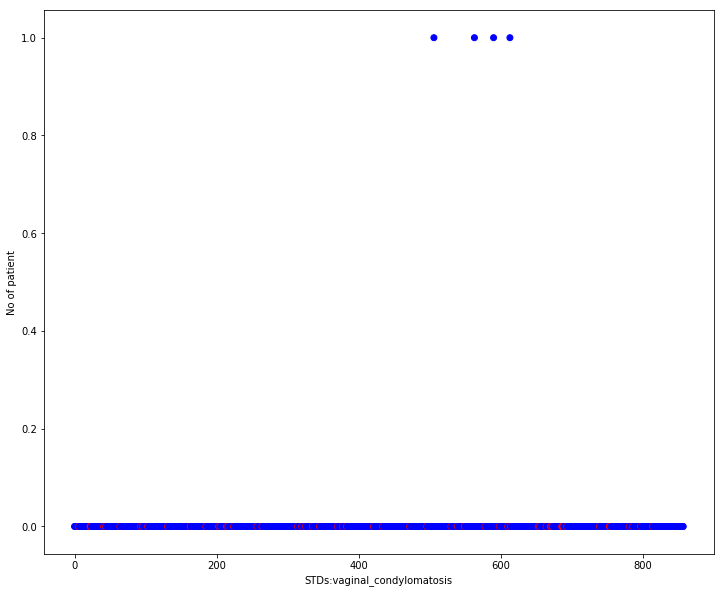

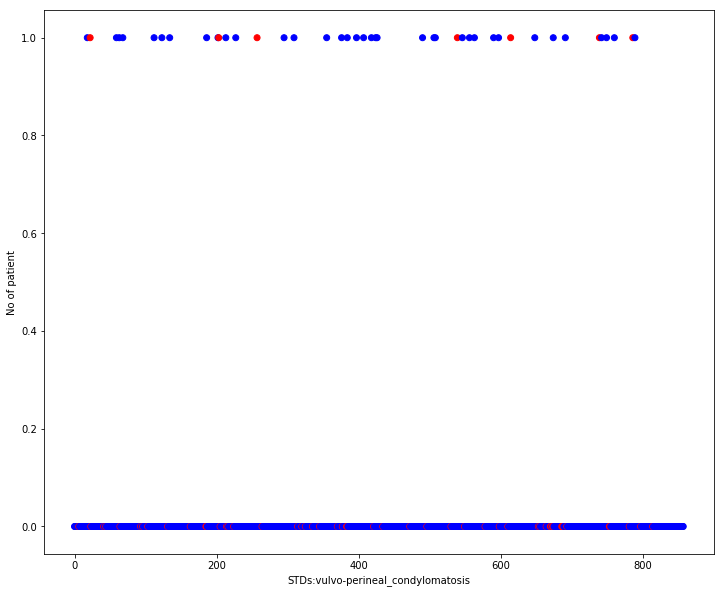

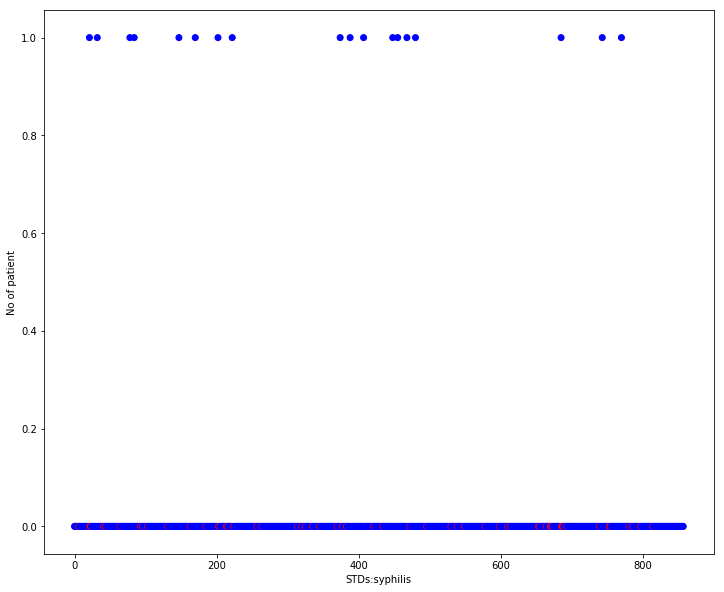

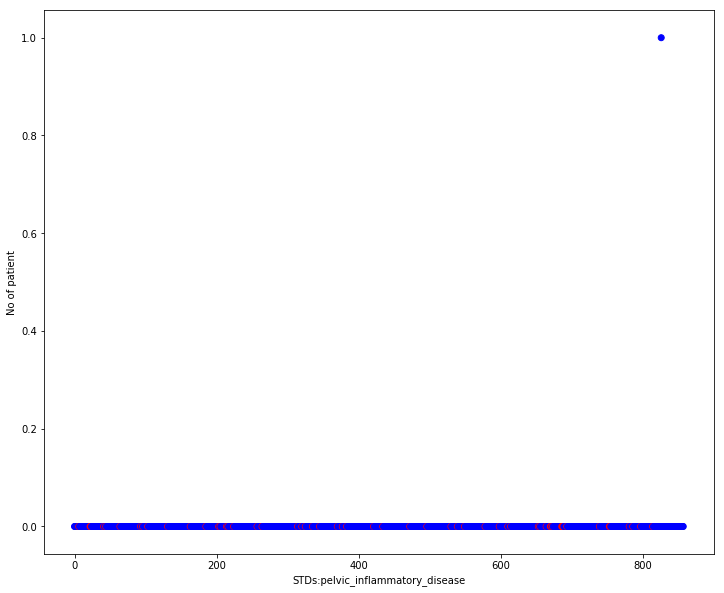

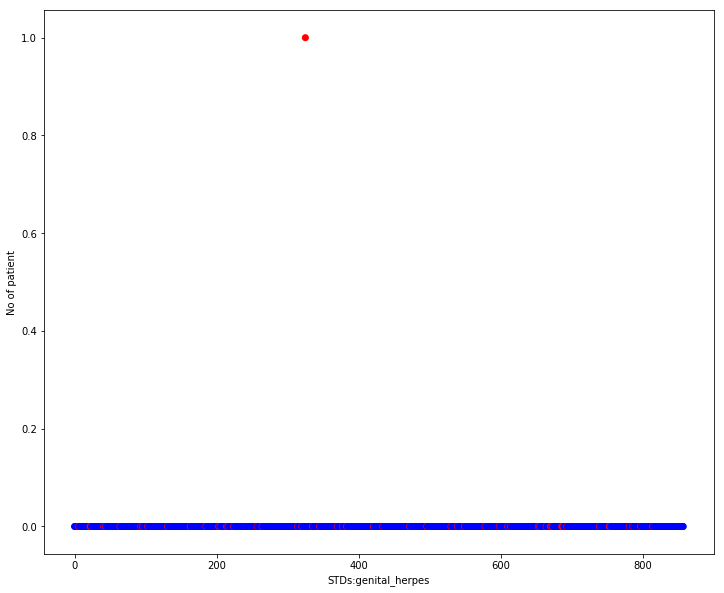

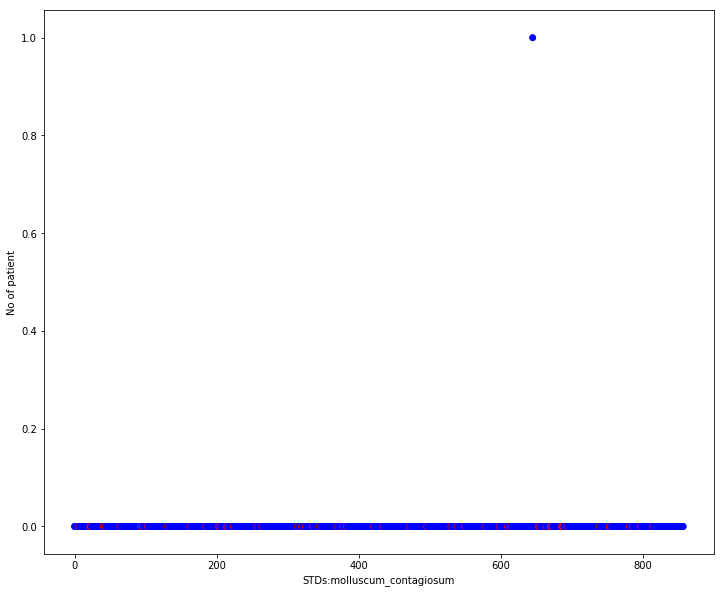

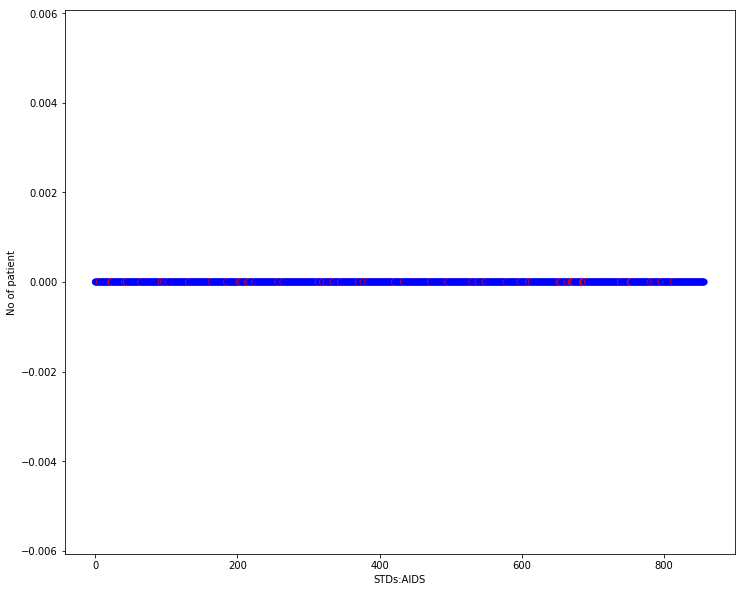

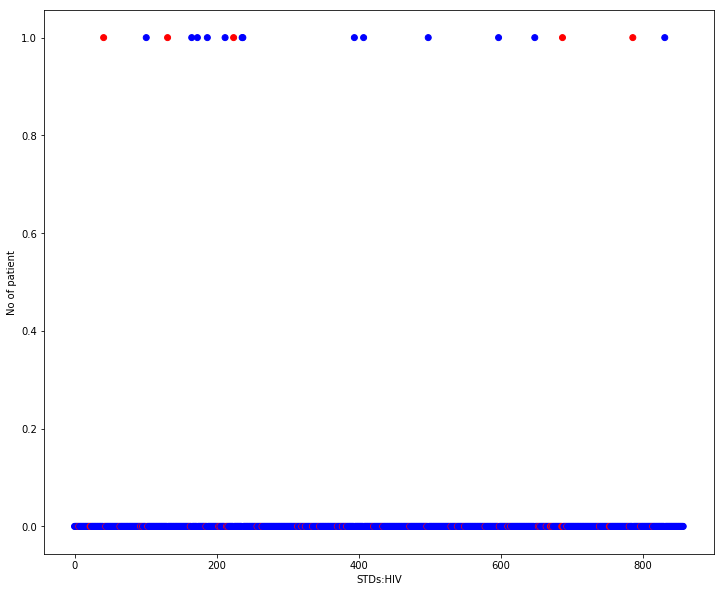

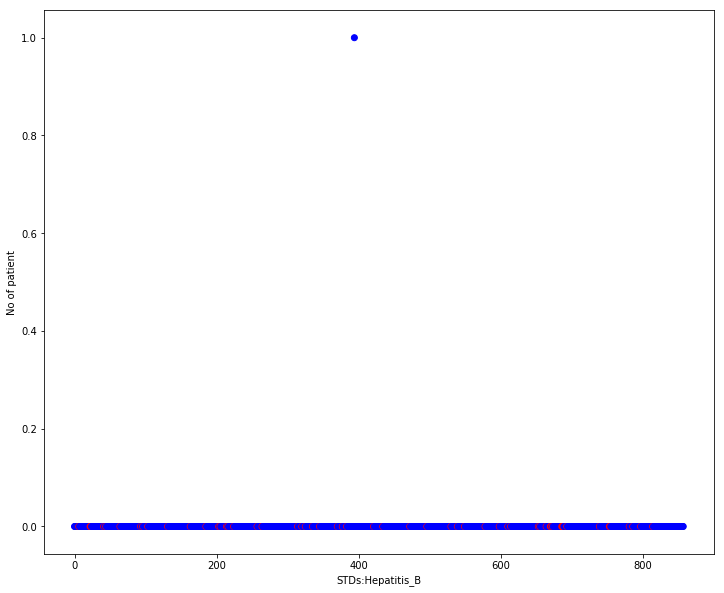

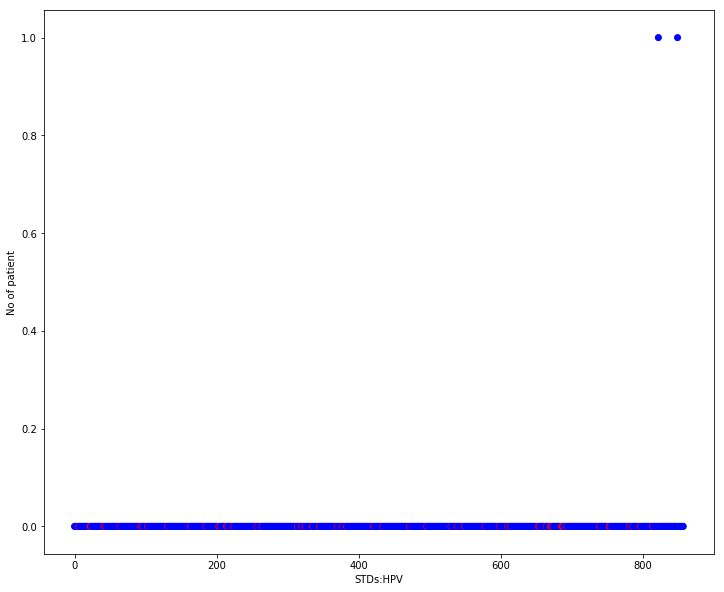

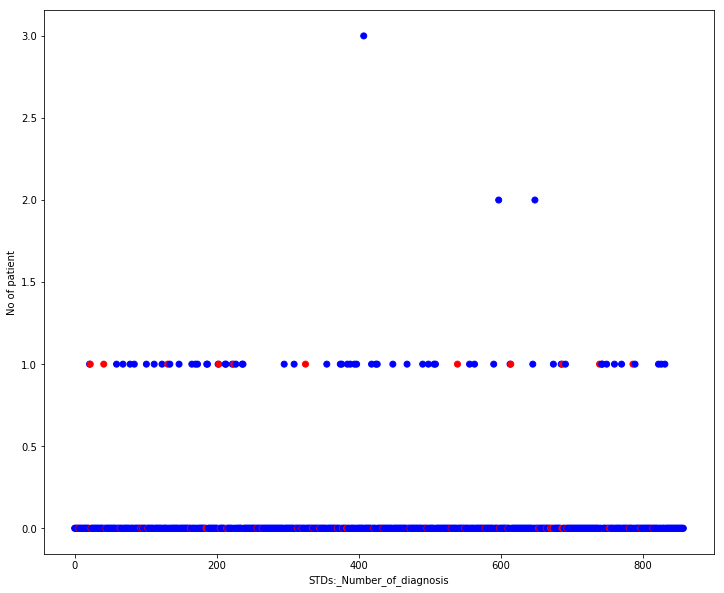

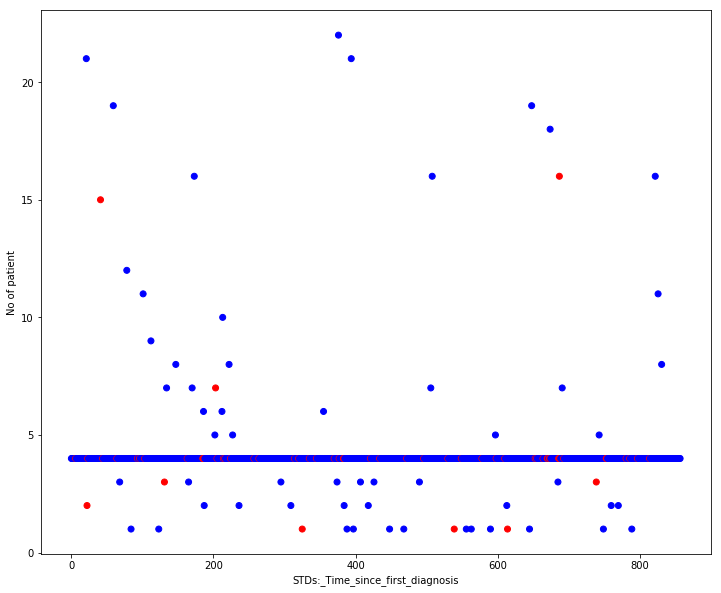

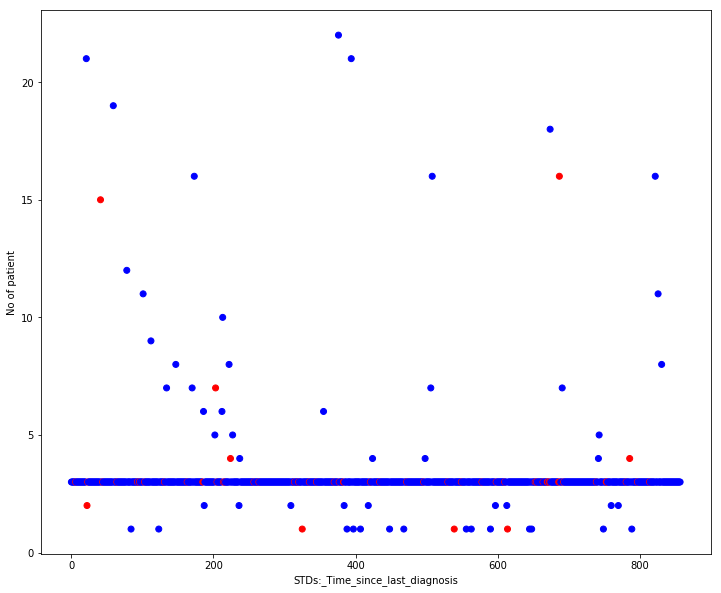

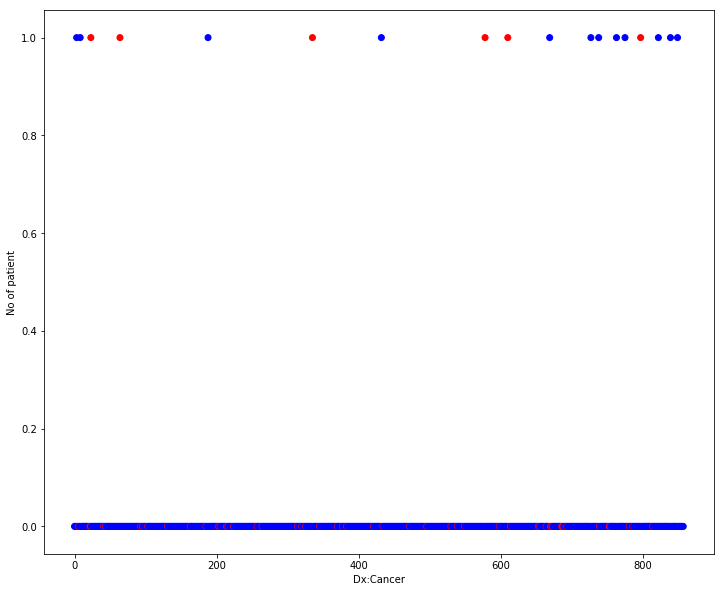

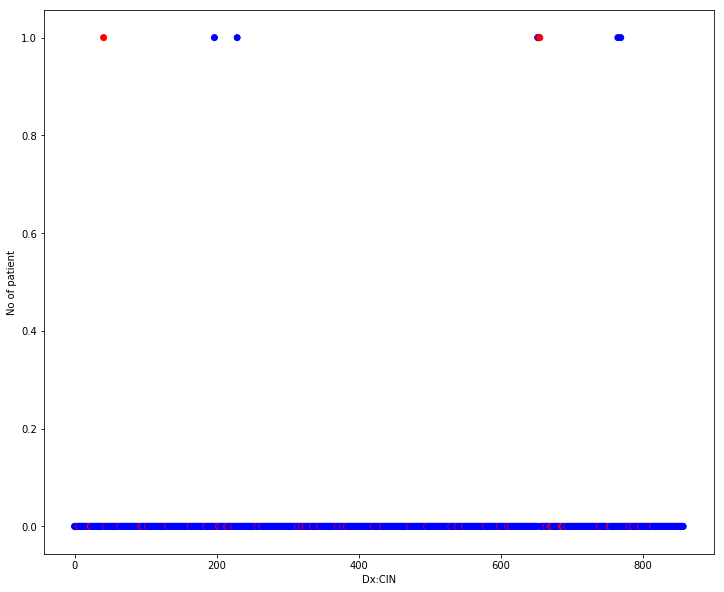

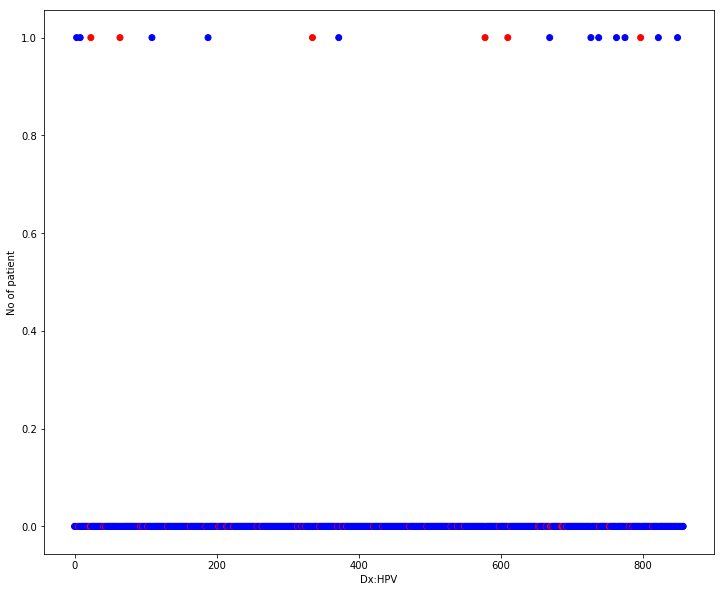

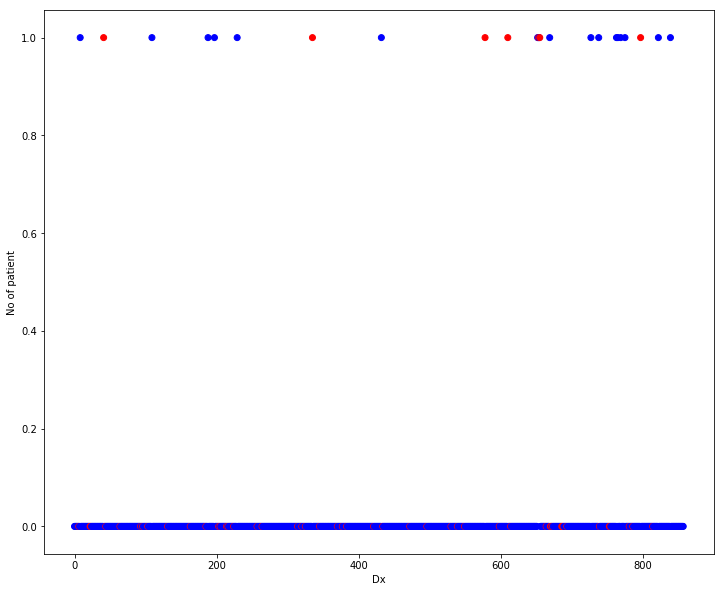

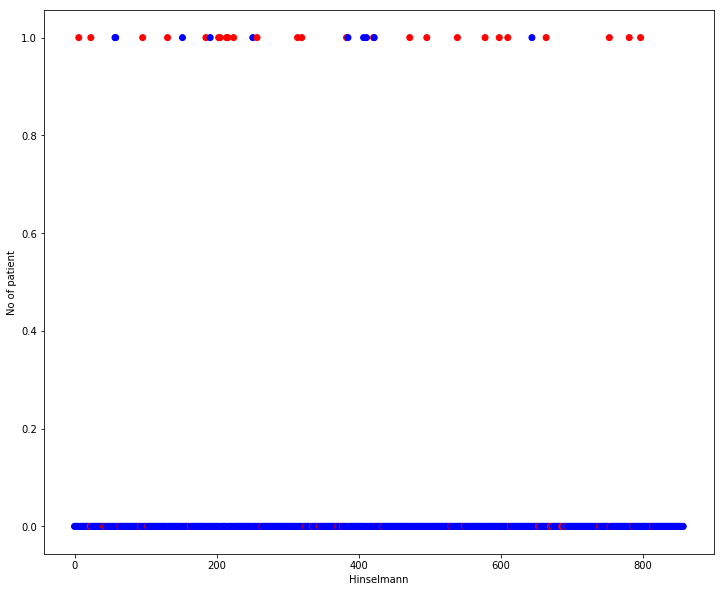

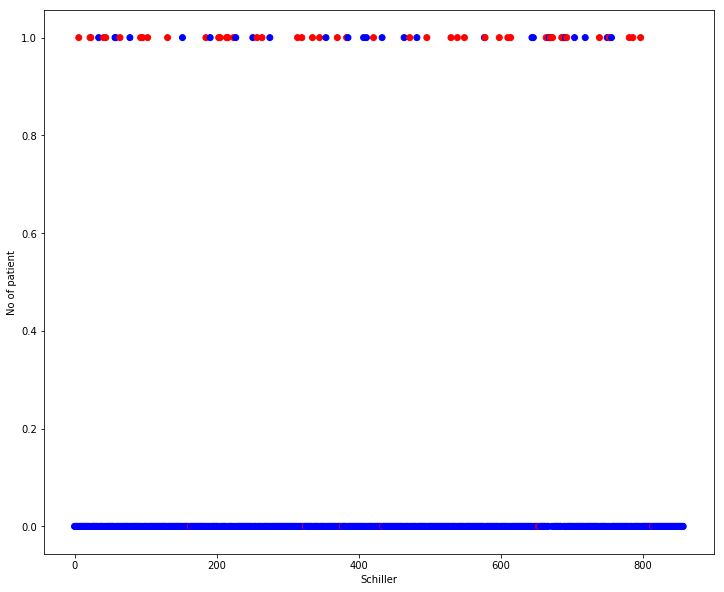

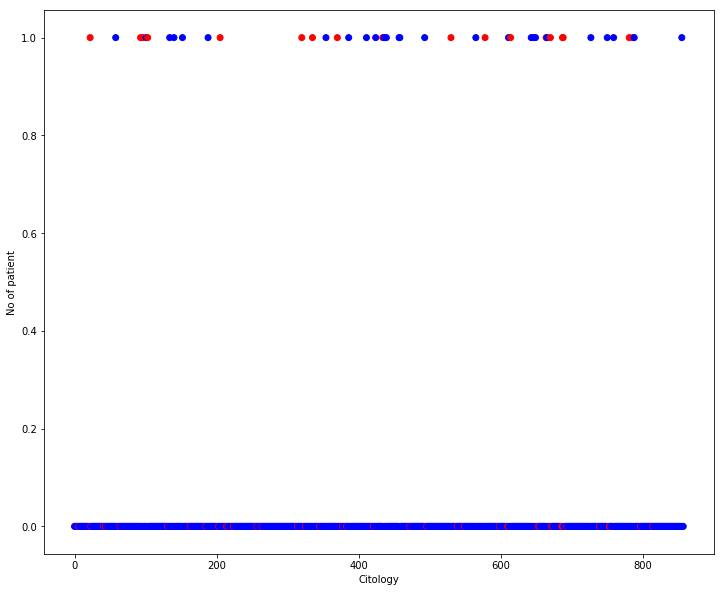

In [36]:
rcParams['figure.figsize']=12,10
_ = df.fillna(df.median())
for var in _.drop(labels='Biopsy',axis=1):
        plt.scatter(_.index,_[var],c=_.Biopsy,cmap=cmap)
        plt.xlabel(var)
        plt.ylabel('No of patient')
        plt.show()

In [37]:
df.columns

Index(['Age', 'Number_of_sexual_partners', 'First_sexual_intercourse',
       'Num_of_pregnancies', 'Smokes', 'Smokes_(years)', 'Smokes_(packs/year)',
       'Hormonal_Contraceptives', 'Hormonal_Contraceptives_(years)', 'IUD',
       'IUD_(years)', 'STDs', 'STDs_(number)', 'STDs:condylomatosis',
       'STDs:cervical_condylomatosis', 'STDs:vaginal_condylomatosis',
       'STDs:vulvo-perineal_condylomatosis', 'STDs:syphilis',
       'STDs:pelvic_inflammatory_disease', 'STDs:genital_herpes',
       'STDs:molluscum_contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis_B', 'STDs:HPV', 'STDs:_Number_of_diagnosis',
       'STDs:_Time_since_first_diagnosis', 'STDs:_Time_since_last_diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

## plotting numerical features

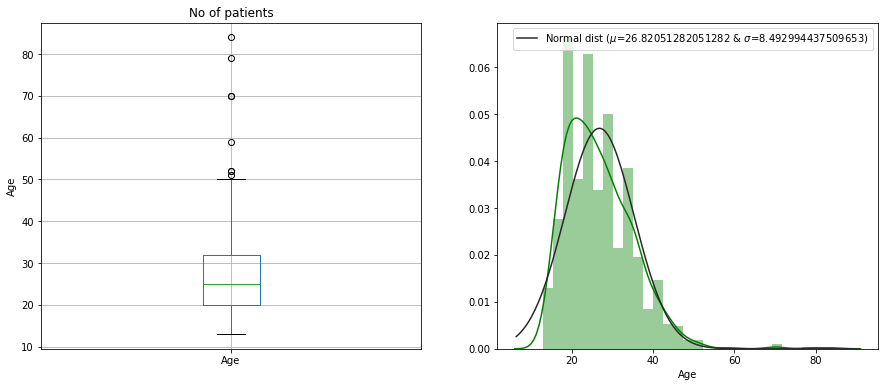

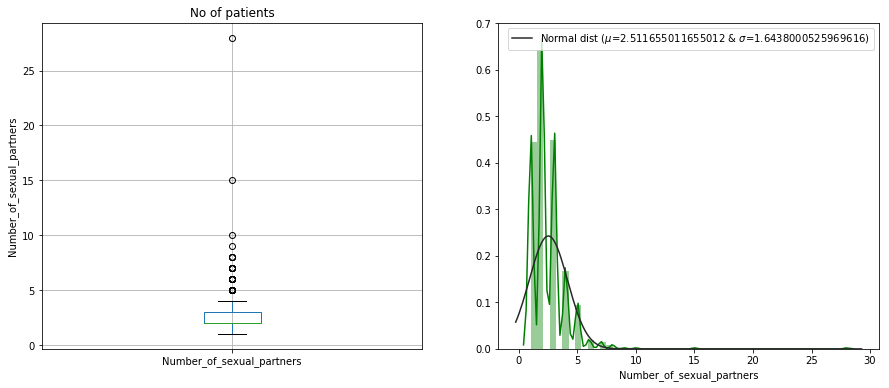

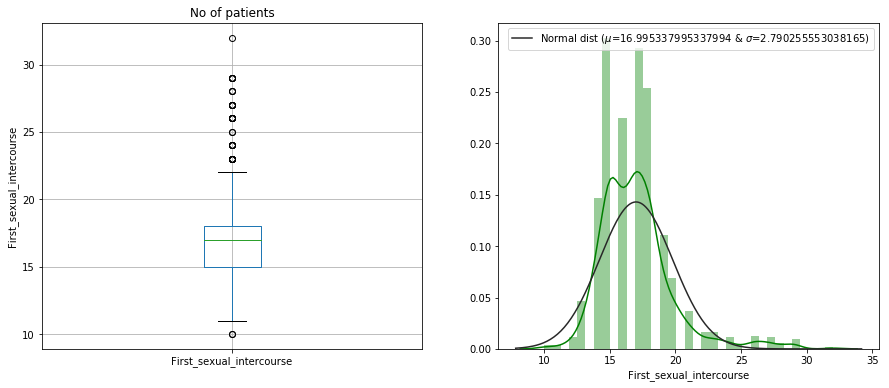

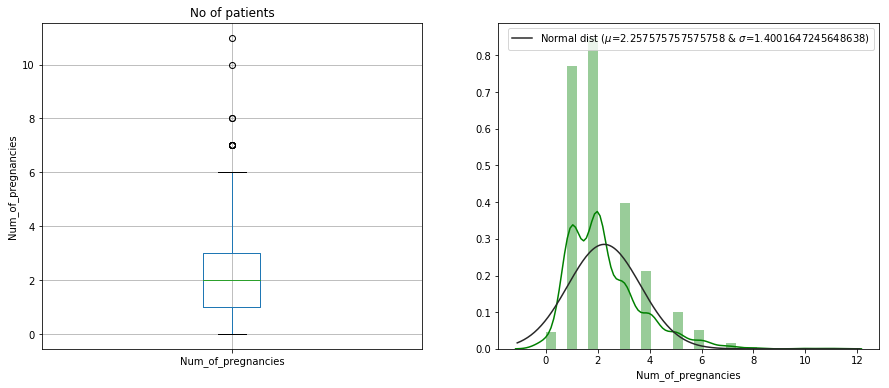

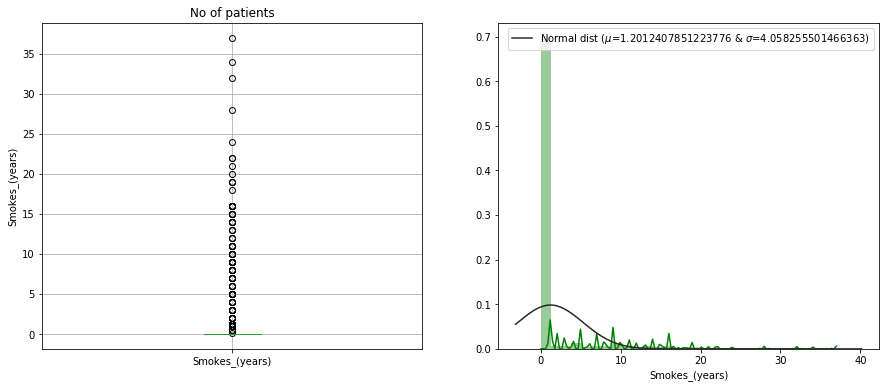

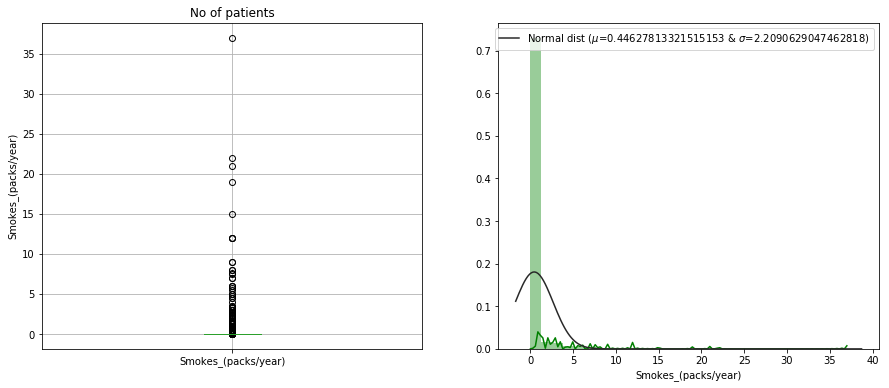

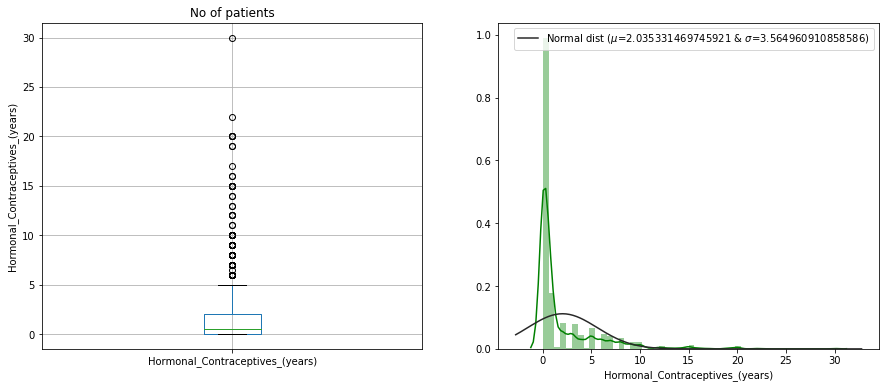

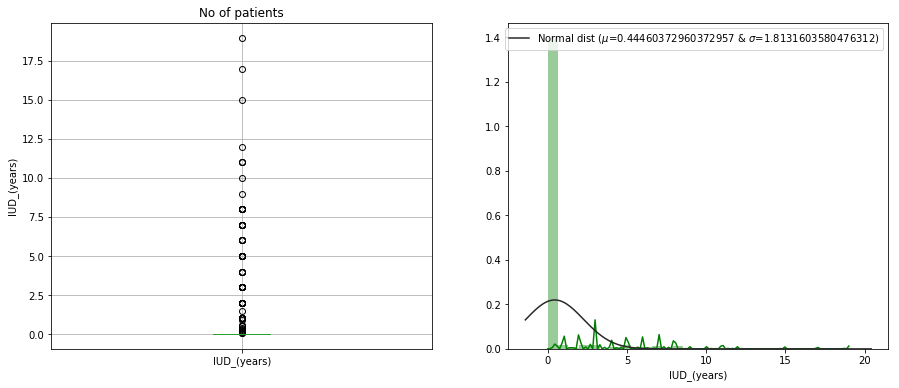

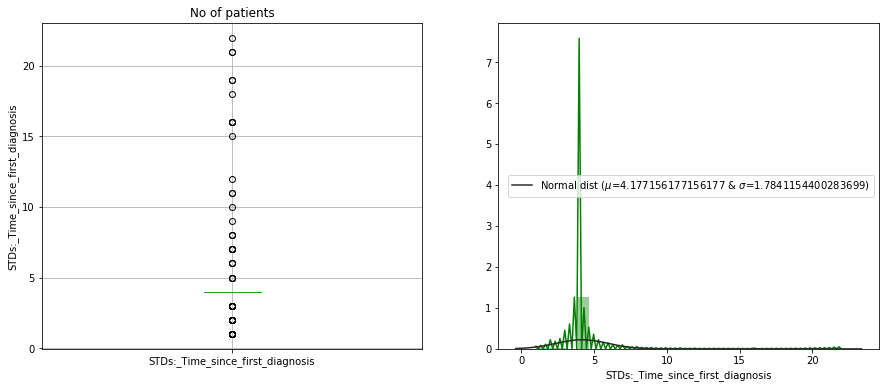

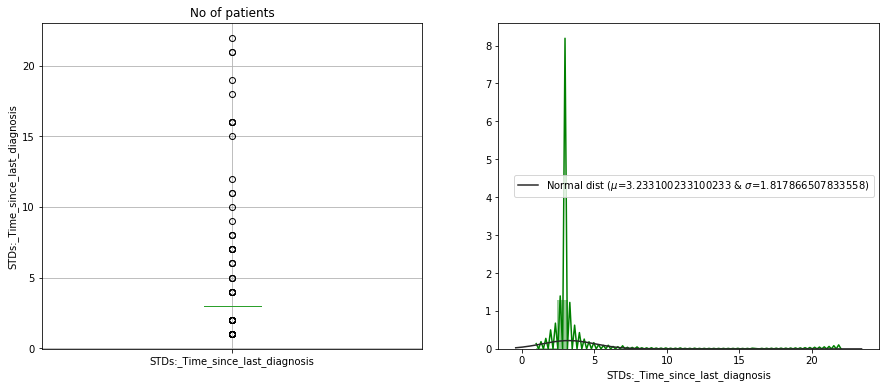

In [38]:
for var in _.columns:
    if(_[var].nunique()>5):
        plt.figure(figsize=(15,6))
        plt.subplot(1, 2, 1)
        fig = _.boxplot(column=var)
        fig.set_title('No of patients')
        fig.set_ylabel(var)

        plt.subplot(1, 2, 2)
        m= _[var].fillna(_[var].median())
        mu,sigma = norm.fit(m)
        sns.distplot(m,fit=norm,color='green')
        plt.legend(['Normal dist ($\mu$={} & $\sigma$={})'.format(mu,sigma)])

## Applying Log transofrmation

In [39]:
_ = df_.copy()

In [40]:
df_.dtypes

Age                                     int64
Number_of_sexual_partners             float64
First_sexual_intercourse              float64
Num_of_pregnancies                    float64
Smokes                                float64
Smokes_(years)                        float64
Smokes_(packs/year)                   float64
Hormonal_Contraceptives               float64
Hormonal_Contraceptives_(years)       float64
IUD                                   float64
IUD_(years)                           float64
STDs                                  float64
STDs_(number)                         float64
STDs:condylomatosis                   float64
STDs:cervical_condylomatosis          float64
STDs:vaginal_condylomatosis           float64
STDs:vulvo-perineal_condylomatosis    float64
STDs:syphilis                         float64
STDs:pelvic_inflammatory_disease      float64
STDs:genital_herpes                   float64
STDs:molluscum_contagiosum            float64
STDs:AIDS                         

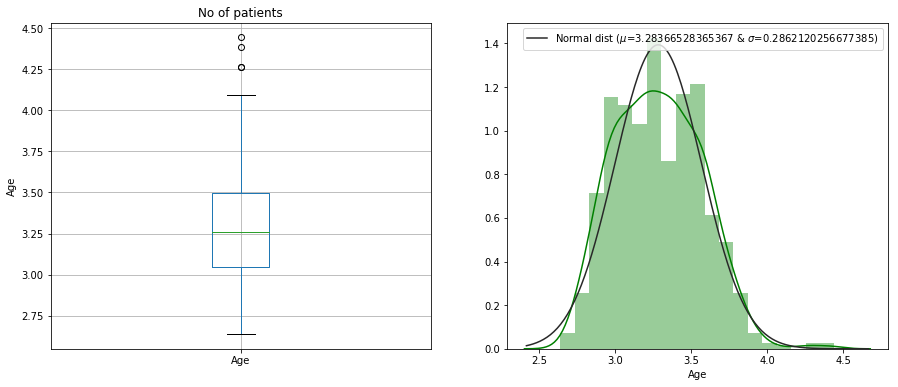

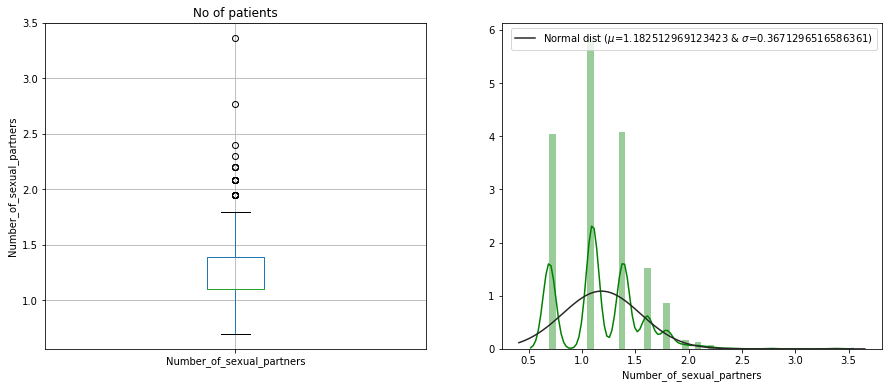

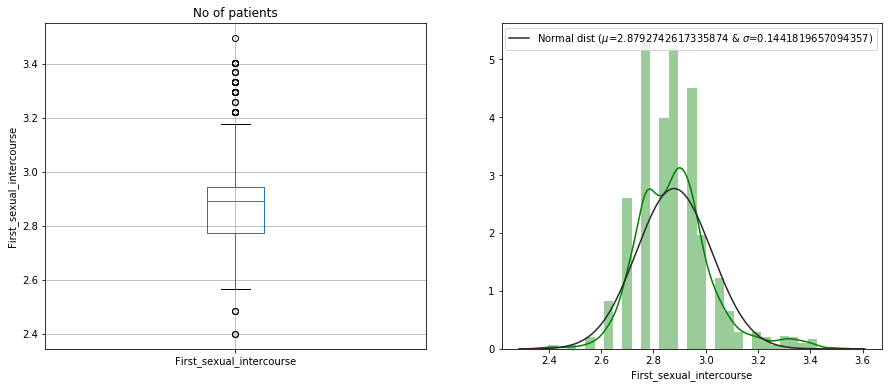

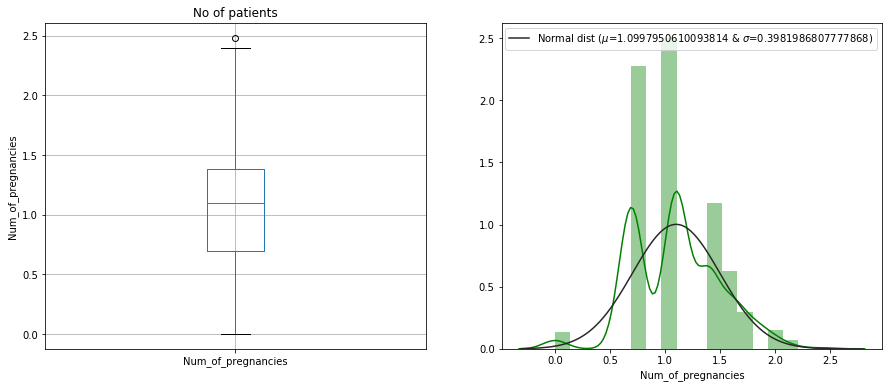

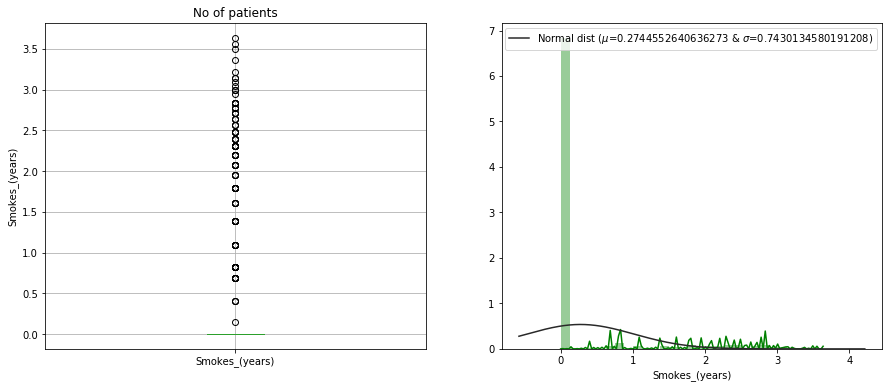

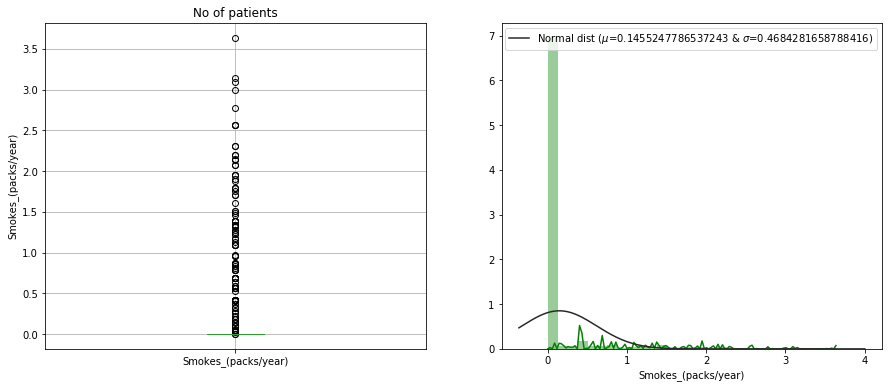

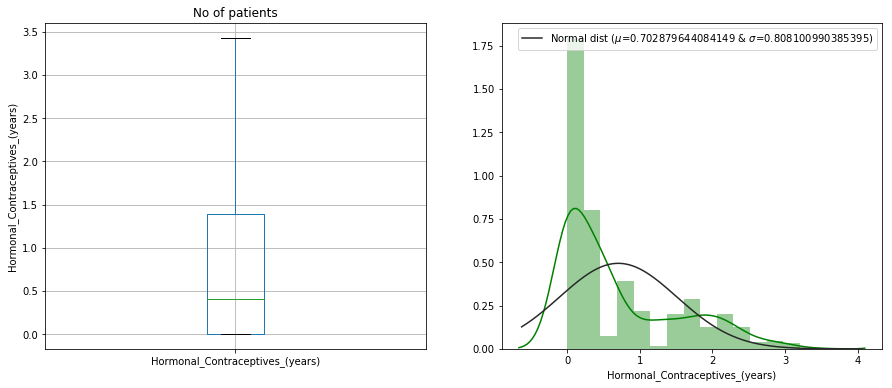

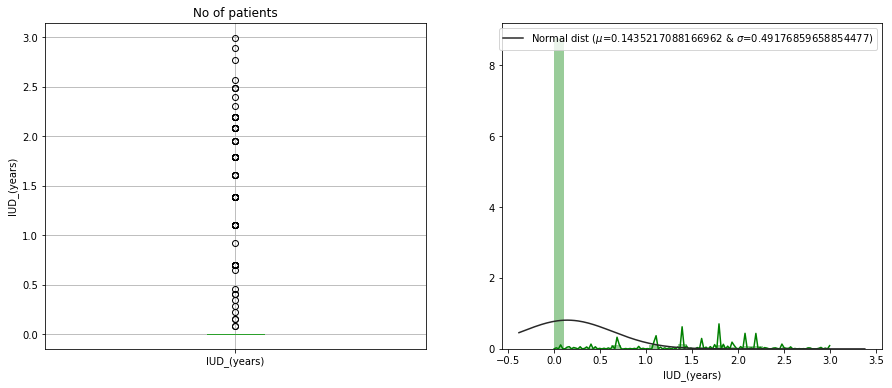

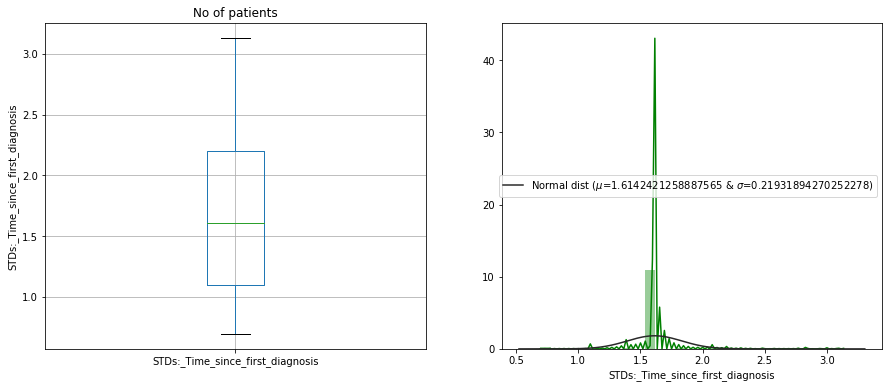

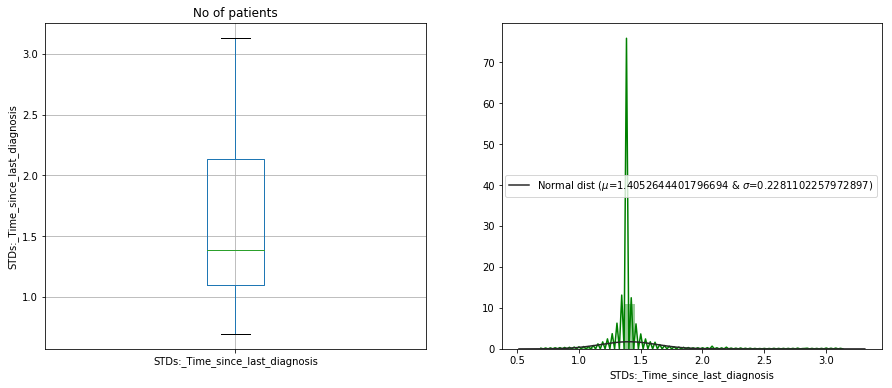

In [41]:

for var in _.columns:
    if(_[var].nunique()>5):
        _[var]  = np.log1p(_[var])
        plt.figure(figsize=(15,6))
        plt.subplot(1, 2, 1)
        fig = _.boxplot(column=var)
        fig.set_title('No of patients')
        fig.set_ylabel(var)

        plt.subplot(1, 2, 2)
        m= _[var].fillna(_[var].median())
        mu,sigma = norm.fit(m)
        sns.distplot(m,fit=norm,color='green')
        plt.legend(['Normal dist ($\mu$={} & $\sigma$={})'.format(mu,sigma)],loc='Best')

In [42]:
df_.head()

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_(years),Smokes_(packs/year),Hormonal_Contraceptives,Hormonal_Contraceptives_(years),IUD,IUD_(years),STDs,STDs_(number),STDs:condylomatosis,STDs:cervical_condylomatosis,STDs:vaginal_condylomatosis,STDs:vulvo-perineal_condylomatosis,STDs:syphilis,STDs:pelvic_inflammatory_disease,STDs:genital_herpes,STDs:molluscum_contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis_B,STDs:HPV,STDs:_Number_of_diagnosis,STDs:_Time_since_first_diagnosis,STDs:_Time_since_last_diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0


****continues :10****<br>
(int) Age<br> 
(int) Number of sexual partners <br>
(int) First sexual intercourse (age) <br>
(int) Num of pregnancies <br>
(int) STDs: Number of diagnosis<br>
(int) STDs: Time since first diagnosis <br>
(int) STDs: Time since last diagnosis <br>
(int) IUD (years) <br>
(int) STDs (number) <br>
(int) Hormonal Contraceptives (years)<br>

****Discrete varibles:17****<br>
(bool) Smokes <br>
(bool) Smokes (years) <br>
(bool) Smokes (packs/year) <br>
(bool) Hormonal Contraceptives <br>
(bool) IUD <br>
(bool) STDs <br>
(bool) STDs:condylomatosis <br>
(bool) STDs:cervical condylomatosis <br>
(bool) STDs:vaginal condylomatosis <br>
(bool) STDs:vulvo-perineal condylomatosis <br>
(bool) STDs:syphilis <br>
(bool) STDs:pelvic inflammatory disease <br>
(bool) STDs:genital herpes <br>
(bool) STDs:molluscum contagiosum <br>
(bool) STDs:AIDS <br>
(bool) STDs:HIV <br>
(bool) STDs:Hepatitis B <br>
(bool) STDs:HPV <br>
(bool) Dx:Cancer <br>
(bool) Dx:CIN <br>
(bool) Dx:HPV <br>
(bool) Dx <br>
(bool) Hinselmann: <br>
(bool) Schiller:  <br>
(bool) Cytology: <br>

    
****Binary varible:<br>****
(bool) Biopsy: target variable<br>




## Corrleation 

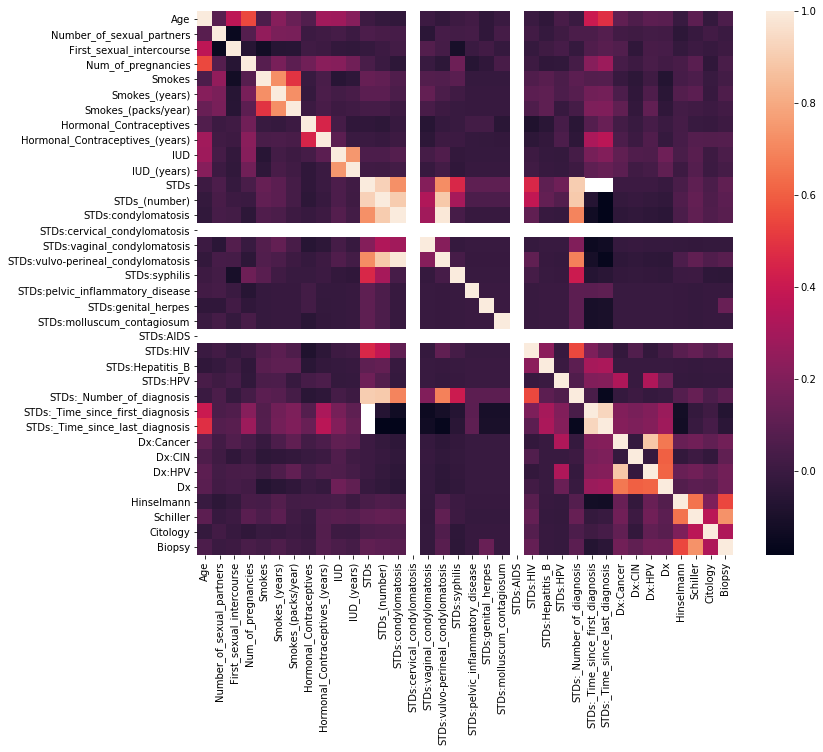

In [43]:
corr = df.corr()
sns.heatmap(corr)

## imputing missing values

In [44]:
def fillna_zero(df):
    _ = df.copy()
    _ = _.fillna(0)
    return _

def median_values(df):
    _ = df.copy()
    _ = _.fillna(_.median())
    return _

def largest_value(df):
    _ = df.copy()
    _ = _.fillna(-999)
    return _

In [45]:
run_experiments([fillna_zero,median_values,largest_value])

,name,score,+-score_std,score_min,score_max,execution time
2,largest_value,0.953803,0.034847,0.904856,0.985884,0.75s
1,median_values,0.952759,0.038849,0.892045,0.987784,0.67s
0,fillna_zero,0.943096,0.049345,0.876906,0.985884,0.76s


## Replacing the missing values with the median values 

In [46]:
df = df.fillna(df.median())
score = cross_val_score(estimator=RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1),X=df.drop(labels='Biopsy',axis=1),y=df.Biopsy.values,cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True),scoring='roc_auc')
score.mean(),score.std(),score.min(),score.max()

(0.9478289102202148,
 0.043572059527329975,
 0.8767045454545455,
 0.9892045454545455)

In [47]:
df.head()

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_(years),Smokes_(packs/year),Hormonal_Contraceptives,Hormonal_Contraceptives_(years),IUD,IUD_(years),STDs,STDs_(number),STDs:condylomatosis,STDs:cervical_condylomatosis,STDs:vaginal_condylomatosis,STDs:vulvo-perineal_condylomatosis,STDs:syphilis,STDs:pelvic_inflammatory_disease,STDs:genital_herpes,STDs:molluscum_contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis_B,STDs:HPV,STDs:_Number_of_diagnosis,STDs:_Time_since_first_diagnosis,STDs:_Time_since_last_diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0


## creating the new features based on the same null values

In [48]:
def duplicates_nan(df):
    _  = df.copy()
    d = pd.DataFrame(index = _.index)
    d['STDs:_Time_since_first_diagnosis_null'] = np.where(_['STDs:_Time_since_first_diagnosis'].isnull(),1,0)
    d['IUD_years_null'] = np.where(_['IUD'].isnull(),1,0)
    d['Hormonal_Contraceptives_years_null'] = np.where(_['Hormonal_Contraceptives'].isnull(),1,0)
    d['STDs_NUll'] = np.where(_['STDs'].isnull(),0,1) 
    _ = pd.concat([_,d], axis = 1)
    return _,d

In [49]:
_,nan = duplicates_nan(df_)
_.fillna(_.median(),inplace=True)

In [50]:
df = pd.concat([df,nan],axis=1)

In [51]:
score = cross_val_score(estimator=RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1),X=df.drop(labels='Biopsy',axis=1),y=df.Biopsy.values,cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True),scoring='roc_auc')

In [52]:
score.mean(),score.std(),score.min(),score.max()

(0.9502667984189724, 0.0428600079648526, 0.8863636363636364, 0.9875)

## Feature Generation

- YAFSI : How many years pass after patient had first sexual intercourse
- SSY : How many years patient did not smoke
- SPYP : After first sexual intercourse how many partners patients had percentage.
- SP: Smoking percentage over age.
- HCP : Hormonal Contraceptices percentage over age
- TSP : Total pack of cigarettes of patient smoked
- NPP : Number of pregnancies percantage over age
- NSPP: Number of sexual partners percentage over age
- TBD : Time betweem diagnosis
- NPSP : Average pregnancy over one sexual partner

In [53]:
def feature_generations(df):
    _ = df.copy()
    _['YAFSI'] = df_['Age'] - _['First_sexual_intercourse']
    _['SSY'] = _['Age'] - _['Smokes_(years)']
    _['SPYP'] = _['Number_of_sexual_partners'] / _['YAFSI']
    _['SP'] = _['Smokes_(years)'] / _['Age']
    _['HCP'] = _['Hormonal_Contraceptives_(years)'] / _['Age']
    _['TSP'] = _['Smokes_(packs/year)'] * _['Smokes_(years)']
    _['NPP'] = _['Num_of_pregnancies'] / _['Age']
    _['NSPP'] = _['Number_of_sexual_partners'] / _['Age']
    _['NPSP'] = _['Num_of_pregnancies'] / _['Number_of_sexual_partners']
    _[_ == np.inf].any()
    
    return _

In [54]:
df.head()

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_(years),Smokes_(packs/year),Hormonal_Contraceptives,Hormonal_Contraceptives_(years),IUD,IUD_(years),STDs,STDs_(number),STDs:condylomatosis,STDs:cervical_condylomatosis,STDs:vaginal_condylomatosis,STDs:vulvo-perineal_condylomatosis,STDs:syphilis,STDs:pelvic_inflammatory_disease,STDs:genital_herpes,STDs:molluscum_contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis_B,STDs:HPV,STDs:_Number_of_diagnosis,STDs:_Time_since_first_diagnosis,STDs:_Time_since_last_diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy,STDs:_Time_since_first_diagnosis_null,IUD_years_null,Hormonal_Contraceptives_years_null,STDs_NUll
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,1,0,1,0,0,0,0,0,1,0,0,1
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1


In [55]:
_ = feature_generations(df)

In [56]:
_[_ == np.inf].any()

Age                                      False
Number_of_sexual_partners                False
First_sexual_intercourse                 False
Num_of_pregnancies                       False
Smokes                                   False
Smokes_(years)                           False
Smokes_(packs/year)                      False
Hormonal_Contraceptives                  False
Hormonal_Contraceptives_(years)          False
IUD                                      False
IUD_(years)                              False
STDs                                     False
STDs_(number)                            False
STDs:condylomatosis                      False
STDs:cervical_condylomatosis             False
STDs:vaginal_condylomatosis              False
STDs:vulvo-perineal_condylomatosis       False
STDs:syphilis                            False
STDs:pelvic_inflammatory_disease         False
STDs:genital_herpes                      False
STDs:molluscum_contagiosum               False
STDs:AIDS    

In [57]:
_.replace(np.inf,0,inplace=True)

In [58]:
_.fillna(0,inplace=True)

In [59]:
score = cross_val_score(estimator=RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1),X=_.drop(labels='Biopsy',axis=1),y=_.Biopsy.values,cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True),scoring='roc_auc')

In [60]:
score.mean(),score.std(),score.min(),score.max()

(0.957271315640881,
 0.03822243527103472,
 0.8863636363636364,
 0.9897727272727272)

In [61]:
df = _

In [62]:
df.head(15)

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_(years),Smokes_(packs/year),Hormonal_Contraceptives,Hormonal_Contraceptives_(years),IUD,IUD_(years),STDs,STDs_(number),STDs:condylomatosis,STDs:cervical_condylomatosis,STDs:vaginal_condylomatosis,STDs:vulvo-perineal_condylomatosis,STDs:syphilis,STDs:pelvic_inflammatory_disease,STDs:genital_herpes,STDs:molluscum_contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis_B,STDs:HPV,STDs:_Number_of_diagnosis,STDs:_Time_since_first_diagnosis,STDs:_Time_since_last_diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy,STDs:_Time_since_first_diagnosis_null,IUD_years_null,Hormonal_Contraceptives_years_null,STDs_NUll,YAFSI,SSY,SPYP,SP,HCP,TSP,NPP,NSPP,NPSP
0,18,4.0,15.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1,3.0,18.000000,1.333333,0.000000,0.000000,0.000000,0.055556,0.222222,0.250000
1,15,1.0,14.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1,1.0,15.000000,1.000000,0.000000,0.000000,0.000000,0.066667,0.066667,1.000000
2,34,1.0,17.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1,17.0,34.000000,0.058824,0.000000,0.000000,0.000000,0.029412,0.029412,1.000000
3,52,5.0,16.0,4.0,1.0,37.000000,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,1,0,1,0,0,0,0,0,1,0,0,1,36.0,15.000000,0.138889,0.711538,0.057692,1369.000000,0.076923,0.096154,0.800000
4,46,3.0,21.0,4.0,0.0,0.000000,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1,25.0,46.000000,0.120000,0.000000,0.326087,0.000000,0.086957,0.065217,1.333333
5,42,3.0,23.0,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1,19.0,42.000000,0.157895,0.000000,0.000000,0.000000,0.047619,0.071429,0.666667
6,51,3.0,17.0,6.0,1.0,34.000000,3.4,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,1,1,0,1,1,0,0,1,34.0,17.000000,0.088235,0.666667,0.000000,115.600000,0.117647,0.058824,2.000000
7,26,1.0,26.0,3.0,0.0,0.000000,0.0,1.0,2.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,26.000000,0.000000,0.000000,0.076923,0.000000,0.115385,0.038462,3.000000
8,45,1.0,20.0,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,1,0,1,1,0,0,0,0,1,0,0,1,25.0,45.000000,0.040000,0.000000,0.000000,0.000000,0.111111,0.022222,5.000000
9,44,3.0,15.0,2.0,1.0,1.266973,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,0,0,0,0,0,0,0,1,1,0,1,29.0,42.733027,0.103448,0.028795,0.000000,3.547524,0.045455,0.068182,0.666667


In [63]:
df.isnull().sum()

Age                                      0
Number_of_sexual_partners                0
First_sexual_intercourse                 0
Num_of_pregnancies                       0
Smokes                                   0
Smokes_(years)                           0
Smokes_(packs/year)                      0
Hormonal_Contraceptives                  0
Hormonal_Contraceptives_(years)          0
IUD                                      0
IUD_(years)                              0
STDs                                     0
STDs_(number)                            0
STDs:condylomatosis                      0
STDs:cervical_condylomatosis             0
STDs:vaginal_condylomatosis              0
STDs:vulvo-perineal_condylomatosis       0
STDs:syphilis                            0
STDs:pelvic_inflammatory_disease         0
STDs:genital_herpes                      0
STDs:molluscum_contagiosum               0
STDs:AIDS                                0
STDs:HIV                                 0
STDs:Hepati

## Feature Scaling

In [64]:
continuous  = ['Age','Number_of_sexual_partners','First_sexual_intercourse','Num_of_pregnancies','STDs:_Number_of_diagnosis','STDs:_Time_since_first_diagnosis','STDs:_Time_since_last_diagnosis','IUD_(years)','STDs_(number)','Hormonal_Contraceptives_(years)','YAFSI','SSY','SPYP','SP','HCP','TSP','NPP','NSPP','NPSP']

In [65]:
def original(df):
    _ = df.copy()
    return df

def feature_scaling(df):
    _ = df.copy()
    for var in continuous:
        _[var] = np.log1p(_[var])
    return _

In [66]:
_ = original(df)

In [67]:
score = cross_val_score(estimator=RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1),X=_.drop(labels='Biopsy',axis=1),y=_.Biopsy.values,cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True),scoring='roc_auc')
score.mean(),score.std(),score.min(),score.max()

(0.957271315640881,
 0.03822243527103472,
 0.8863636363636364,
 0.9897727272727272)

In [68]:
_  = feature_scaling(df)

In [69]:
_.fillna(df.median(),inplace=True)

In [70]:
score = cross_val_score(estimator=RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1),X=_.drop(labels='Biopsy',axis=1),y=_.Biopsy.values,cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True),scoring='roc_auc')
score.mean(),score.std(),score.min(),score.max()

(0.9564222190852625,
 0.03806361634115743,
 0.8857954545454545,
 0.9886363636363636)

In [71]:
df_final = _

## Model Building

In [72]:
def feature_importances(clf):
    plt.figure(figsize=(12,10))
    features = pd.DataFrame(clf.feature_importances_,columns=['Feature'],index = X.columns).reset_index().sort_values(by='Feature',ascending=False)
    sns.barplot(y='index',x='Feature',data=features)

In [73]:
X = df_final.drop(labels='Biopsy',axis=1)
y = df_final['Biopsy']

In [74]:
X.head()

,Age,Number_of_sexual_partners,First_sexual_intercourse,Num_of_pregnancies,Smokes,Smokes_(years),Smokes_(packs/year),Hormonal_Contraceptives,Hormonal_Contraceptives_(years),IUD,IUD_(years),STDs,STDs_(number),STDs:condylomatosis,STDs:cervical_condylomatosis,STDs:vaginal_condylomatosis,STDs:vulvo-perineal_condylomatosis,STDs:syphilis,STDs:pelvic_inflammatory_disease,STDs:genital_herpes,STDs:molluscum_contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis_B,STDs:HPV,STDs:_Number_of_diagnosis,STDs:_Time_since_first_diagnosis,STDs:_Time_since_last_diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,STDs:_Time_since_first_diagnosis_null,IUD_years_null,Hormonal_Contraceptives_years_null,STDs_NUll,YAFSI,SSY,SPYP,SP,HCP,TSP,NPP,NSPP,NPSP
0,2.944439,1.609438,2.772589,0.693147,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438,1.386294,0,0,0,0,0,0,0,1,0,0,1,1.386294,2.944439,0.847298,0.000000,0.000000,0.000000,0.054067,0.200671,0.223144
1,2.772589,0.693147,2.708050,0.693147,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438,1.386294,0,0,0,0,0,0,0,1,0,0,1,0.693147,2.772589,0.693147,0.000000,0.000000,0.000000,0.064539,0.064539,0.693147
2,3.555348,0.693147,2.890372,0.693147,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438,1.386294,0,0,0,0,0,0,0,1,0,0,1,2.890372,3.555348,0.057158,0.000000,0.000000,0.000000,0.028988,0.028988,0.693147
3,3.970292,1.791759,2.833213,1.609438,1.0,37.0,37.0,1.0,1.386294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438,1.386294,1,0,1,0,0,0,0,1,0,0,1,3.610918,2.772589,0.130053,0.537393,0.056089,7.222566,0.074108,0.091808,0.587787
4,3.850148,1.386294,3.091042,1.609438,0.0,0.0,0.0,1.0,2.772589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438,1.386294,0,0,0,0,0,0,0,1,0,0,1,3.258097,3.850148,0.113329,0.000000,0.282232,0.000000,0.083382,0.063179,0.847298


In [75]:
y

0      0
1      0
2      0
3      0
4      0
5      0
6      1
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     1
23     1
24     0
25     0
26     0
27     0
28     0
29     0
      ..
828    0
829    0
830    0
831    0
832    0
833    0
834    0
835    0
836    0
837    0
838    0
839    0
840    0
841    0
842    0
843    0
844    0
845    0
846    0
847    0
848    0
849    0
850    0
851    0
852    0
853    0
854    0
855    0
856    0
857    0
Name: Biopsy, Length: 858, dtype: int64

In [76]:
Kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [77]:
def cross_cv(clf,X,y):
    Kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    score = cross_val_score(clf,X,y,scoring='roc_auc',cv=Kfold,verbose=1,n_jobs=-1)
    return score

In [78]:
rf = RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1)


In [79]:
score = cross_cv(rf,X.values,y)
score.mean(),score.std(),score.min(),score.max()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


(0.9564222190852625,
 0.03806361634115743,
 0.8857954545454545,
 0.9886363636363636)

In [80]:
rf_500 = RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_split=2,min_samples_leaf=1,
                               max_features=0.2,n_jobs=-1,random_state=1)
score = cross_cv(rf_500,X.values,y)
score.mean(),score.std(),score.min(),score.max()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


(0.9566537267080746,
 0.03686326005989504,
 0.8903409090909091,
 0.9886363636363636)

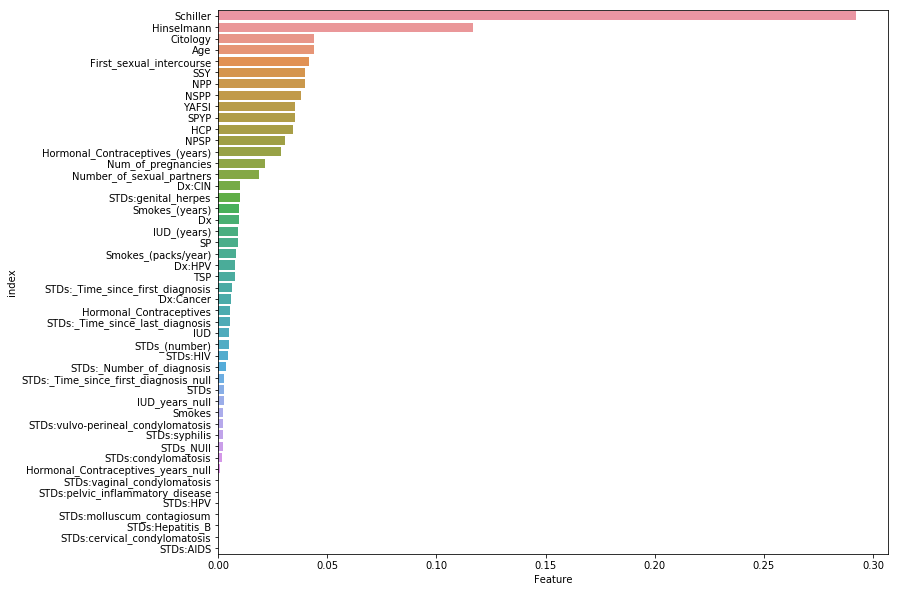

In [81]:
rf_500.fit(X,y)
feature_importances(rf_500)

In [82]:
gbdt = GradientBoostingClassifier(max_depth=30,n_estimators=550,min_samples_leaf=1,min_samples_split=2,subsample=0.8,learning_rate=0.2,random_state=1,verbose=1,max_features='sqrt')
score = score_cv(gbdt,X.values,y)

gbdt.fit(X.values,y)
score.mean(),score.std(),score.min(),score.max()

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1633           0.1637            1.70s
         2           0.1328           0.0091            1.69s
         3           0.1102           0.0150            1.70s
         4           0.0925           0.0048            1.87s
         5           0.0773           0.0107            1.94s
         6           0.0593           0.0090            1.96s
         7           0.0513           0.0048            2.01s
         8           0.0433           0.0059            2.08s
         9           0.0368           0.0048            2.13s
        10           0.0304           0.0046            2.17s
        20           0.0048           0.0003            2.16s
        30           0.0009          -0.0000            2.02s
        40           0.0003          -0.0000            1.80s
        50           0.0002          -0.0000            1.54s
        60           0.0002           0.0000            1.30s
       

(0.9368442970073405,
 0.07138511036827462,
 0.8005681818181819,
 0.9954545454545454)

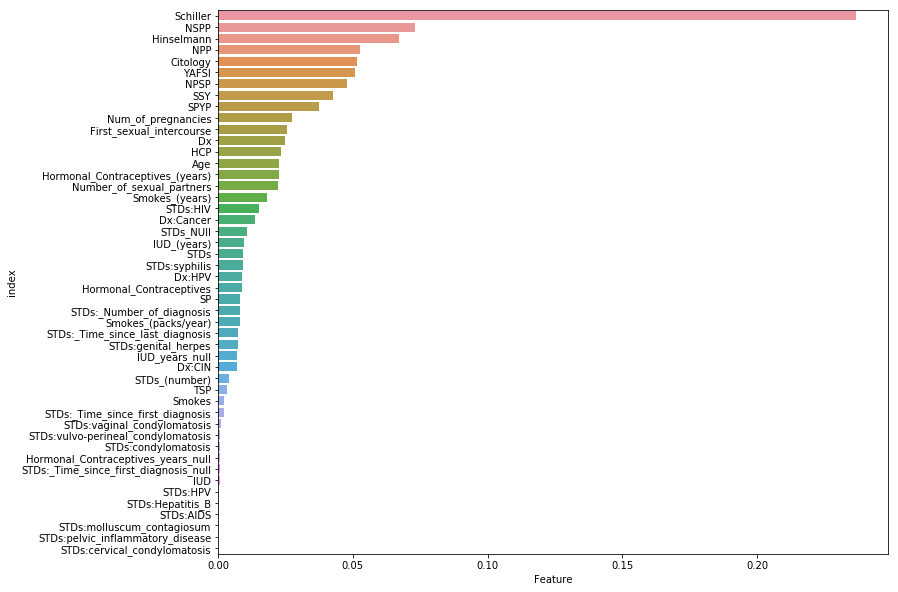

In [83]:
feature_importances(gbdt)

In [84]:
et = ExtraTreesClassifier(n_estimators=300,max_depth=30,max_features='sqrt',random_state=1,n_jobs=-1)
score = cross_cv(et,X.values,y)
score.mean(),score.std(),score.min(),score.max()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


(0.9508642715979672,
 0.04872116664538608,
 0.8616477272727272,
 0.9931818181818182)

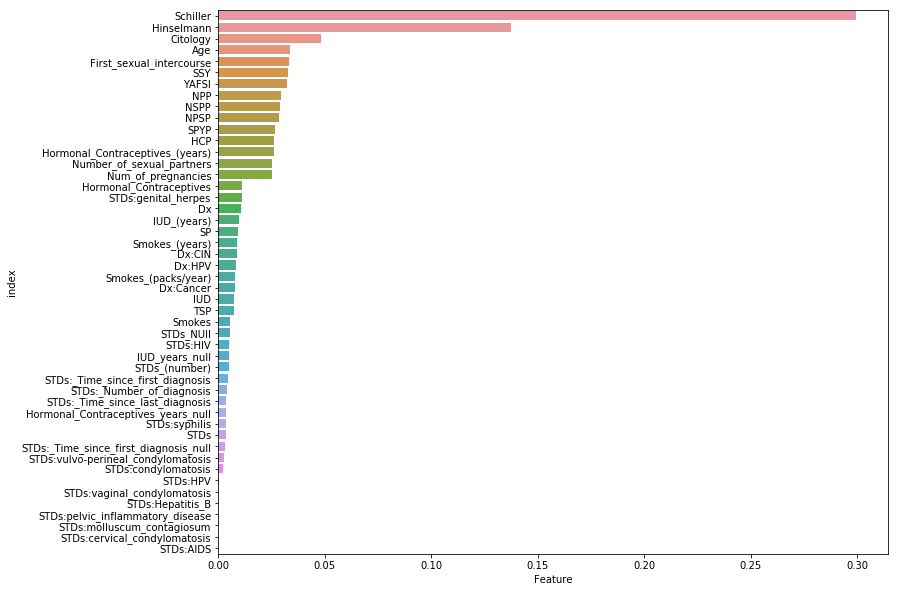

In [85]:
et.fit(X.values,y)
feature_importances(et)

In [86]:
def cross_cv_1(clf,X,y):
    Kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    score = cross_val_score(clf,X,y,scoring='accuracy',cv=Kfold,verbose=1,n_jobs=-1)
    return score

In [87]:
class AveragingModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
  
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
   
    def predict(self, X):
        predictions = np.column_stack([
            model.predict_proba(X)[:,1] for model in self.models_
        ])
        predictions = np.mean(predictions,axis=1)
        _ = predictions>0.5
        _.dtype=np.int8
        return _
    

In [88]:
avg = AveragingModels(models=(et,rf_500,gbdt))

In [89]:
avg.fit(X.values,y.values)
score = cross_cv_1(avg,X.values,y)
score.mean(),score.std()

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1633           0.1637            1.72s
         2           0.1328           0.0091            1.72s
         3           0.1102           0.0150            1.73s
         4           0.0925           0.0048            1.90s
         5           0.0773           0.0107            1.95s
         6           0.0593           0.0090            1.95s
         7           0.0513           0.0048            2.01s
         8           0.0433           0.0059            2.10s
         9           0.0368           0.0048            2.15s
        10           0.0304           0.0046            2.21s
        20           0.0048           0.0003            2.23s
        30           0.0009          -0.0000            2.07s
        40           0.0003          -0.0000            1.83s
        50           0.0002          -0.0000            1.57s
        60           0.0002           0.0000            1.33s
       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


(0.9522099823201415, 0.01007316408758195)

In [90]:
xgb_params={}
xgb_params['objective']='binary:logistic'
xgb_params['eta']=0.03
xgb_params['n_estimators']=1000
xgb_params['max_depth']=30
xgb_params['clsample_bytree']=0.7
xgb_params['subsample']=0.8
xgb_params['silent']=1
xgb_params['n_thread']=-1
xgb_params['tree_methods']='hist'
xgb_params['eval_metric']=['auc']

In [91]:
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X.values,y)
score = cross_cv_1(xgb_model,X.values,y)
score.mean(),score.std()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


(0.9487216102271182, 0.016692909443549845)

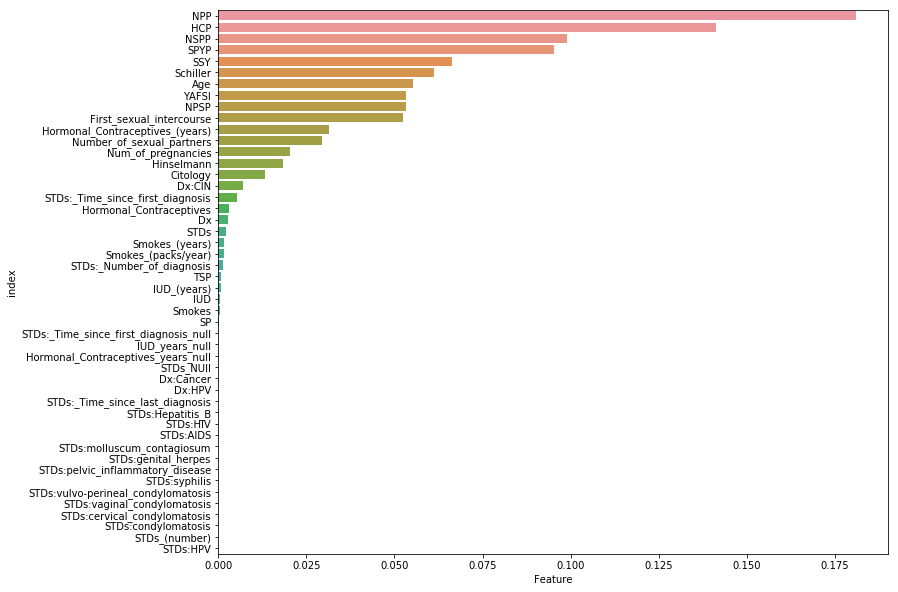

In [92]:
feature_importances(xgb_model)

In [93]:
lgb_params={}
lgb_params['objective']='binary'
lgb_params['metrics']=['rmse']
lgb_params['max_depth']=10
lgb_params['min_data_leaf']=10
lgb_params['learning_rate']=0.1
lgb_params['bagging_fraction']=0.7
lgb_params['feature_fraction']=0.7
lgb_params['bagging_freq']=5
lgb_params['bagging_seed']=1
lgb_params['verbosity']=0
lgb_params['n_estimators']=100

In [94]:
model_lgbm = lgb.LGBMClassifier(**lgb_params)
model_lgbm.fit(X.values,y)
score = cross_cv_1(model_lgbm,X.values,y)
model_lgbm.fit(X.values,y)
score.mean(),score.std()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


(0.9510403916768666, 0.013140250489622437)

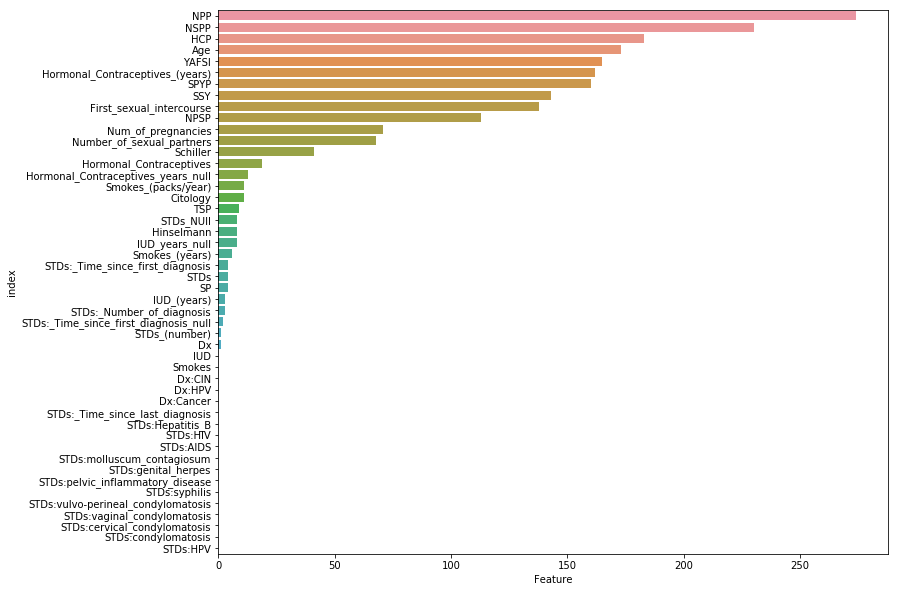

In [95]:
feature_importances(model_lgbm)

In [96]:
clf = AveragingModels(models=(et,rf_500,gbdt,model_lgbm,xgb_model))

In [97]:
score = cross_cv_1(clf,X.values,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


In [98]:
score.mean(),score.std()

(0.9533795729634162, 0.01109651118285169)

In [99]:
clf.fit(X.values,y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1633           0.1637            1.60s
         2           0.1328           0.0091            1.63s
         3           0.1102           0.0150            1.64s
         4           0.0925           0.0048            1.81s
         5           0.0773           0.0107            1.86s
         6           0.0593           0.0090            1.87s
         7           0.0513           0.0048            1.95s
         8           0.0433           0.0059            2.03s
         9           0.0368           0.0048            2.08s
        10           0.0304           0.0046            2.12s
        20           0.0048           0.0003            2.23s
        30           0.0009          -0.0000            2.06s
        40           0.0003          -0.0000            1.82s
        50           0.0002          -0.0000            1.56s
        60           0.0002           0.0000            1.32s
       

AveragingModels(models=(ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=30, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf..., reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=0.8, tree_methods='hist')))

In [100]:
predict = clf.predict(X.values)
predict = pd.DataFrame(predict,columns=['predict'])

In [101]:
_ = pd.concat([df_final,predict],axis=1)
c = _.Biopsy
_ = _.drop(labels='Biopsy',axis=1)
_.insert(48,'Biopsy',value=c)

In [102]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [103]:
confusion_matrix(df_final.Biopsy,predict)

array([[803,   0],
       [  0,  55]])

In [104]:
#_.to_csv('final_data')